In [1]:
pip install rank_bm25

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
  Using cached https://mirrors.aliyun.com/pypi/packages/16/5a/23ed3132063a0684ea66fb410260c71c4ffda3b99f8f1c021d1e245401b5/rank_bm25-0.2.1-py3-none-any.whl (8.5 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sqlite3
import sqlite_utils
from icecream import ic
import jieba
import pandas as pd
import urllib.request
from urllib.parse import quote
from time import sleep
import json
import os
from collections import defaultdict
from rank_bm25 import BM25Okapi
from glob import glob

In [3]:
import jieba.posseg as posseg

In [4]:
from tableQA_single_table import *

In [5]:
conn = sqlite3.connect("finance.db")
finance_meta_df = pd.read_csv("finance_table_desc.csv")
finance_meta_df.to_sql("finance_meta", conn, if_exists = "replace")

In [6]:
db = sqlite_utils.Database(conn)

In [7]:
db["finance_meta"].enable_fts(["all_text_str_elements"])

<Table finance_meta (index, name, id, header, common, title, table_elements, all_text_list, all_text_list_elements, common_words, all_text_str_elements, topic_words, top_topic, max_topic, fkwds, label, other_t)>

In [8]:
data_dir = "../TableQA/TableQA"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
val_dir = os.path.join(data_dir, "val")

In [9]:
cp /home/featurize/TableQA/TableQA/train/train.db train_cp.db

In [10]:
train_conn = sqlite3.connect("train_cp.db")
train_db = sqlite_utils.Database(train_conn)
finance_table_names = list(map(lambda x: x["name"] ,db["finance_meta"].rows))
finance_tables = list(filter(lambda t: t.name in finance_table_names,train_db.tables))

In [11]:
def retrieve_table_in_pd_format(meta_table, table, ori_alias_mapping = dict()):
    meta_df = pd.DataFrame(meta_table.rows)
    name = table.name
    table_meta_s = meta_df[meta_df["name"] == name].iloc[0]
    header = eval(table_meta_s.loc["header"])
    assert type(header) == type([])
    df = pd.DataFrame(table.rows)
    #### tickle duplicate columns
    if len(header) > len(set(header)):
        req = []
        have_req = set([])
        idx = 0
        for h in header:
            if h in have_req:
                idx += 1
                req.append("{}_{}".format(h, idx))
            else:
                req.append(h)
            have_req.add(h)
        header = req
        
    df.columns = header
    if set(ori_alias_mapping.keys()).intersection(set(header)):
        assert len(set(ori_alias_mapping.keys()).intersection(set(header))) == len(set(ori_alias_mapping.keys()))
        for ori_col, alias_col in ori_alias_mapping.items():
            df[alias_col] = df[ori_col].copy()
    return df

In [12]:
def search_tables_on_db_iter(kwords, meta_table, tables):
    if type(kwords) == type(""):
        kwords = [kwords]
    kw_names_dict = dict(map(lambda kw: (kw, map(lambda r: r["name"] ,meta_table.search(kw))), kwords))
    for kw, names in kw_names_dict.items():
        for name in names:
            table = list(filter(lambda t: t.name == name, tables))[0]
            yield (name, kw, retrieve_table_in_pd_format(meta_table, table))

In [13]:
def template_extractor(rows_filtered):
    re_words = re.compile(u"[\u4e00-\u9fa5]+")
    nest_collection = pd.DataFrame(rows_filtered).applymap(lambda x: tuple(sorted(set(re.findall(re_words, x))))).drop_duplicates().values.tolist()
    def flatten_collection(c):
        if not c:
            return c
        if type(c[0]) == type(""):
            return c
        else:
            c = list(c)
        return flatten_collection(reduce(lambda a, b: a + b, map(list ,c)))
    return flatten_collection(nest_collection)

In [14]:
##### kws set if not exit in all finance table :"股票价格" not in 
def search_question(question, meta_table, drop_tags = ("x",), topk = 100, kws = ("股票", "证券")):
    question_token_connected = " ".join(map(lambda ttt2: ttt2[0] ,filter(lambda tt2: tt2[1] not in drop_tags ,map(lambda t2: (t2.word, t2.flag) ,posseg.cut(question)))))
    question_token_connected = " ".join(template_extractor([(question_token_connected,)]))
    #### ('Table_e0ac35f8333a11e99688542696d6e445', '东方 证券 中信证券 买入 光大 证券 兴业 证券 增持')
    if all(map(lambda kw: kw not in question_token_connected.split(" "), kws)) and any(map(lambda kw: kw in question_token_connected, kws)):
        for kw in kws:
            if kw in question_token_connected:
                question_token_connected += " " + kw
    #ic(question_token_connected)
    if not question_token_connected.strip():
        return []

    name_text_str_tuple_set = reduce(lambda a, b: a.union(b) ,map(lambda kw: set(map(lambda r: (r["name"], r["all_text_str_elements"]) ,meta_table.search(kw))), question_token_connected.split(" ")))
    name_text_str_tuple_list = sorted(name_text_str_tuple_set)
    corpus = list(map(lambda t2: t2[1] ,name_text_str_tuple_list))
    tokenized_corpus = [doc.split(" ") for doc in corpus]

    bm25 = BM25Okapi(tokenized_corpus)
    query = question_token_connected
    tokenized_query = query.split(" ")
    doc_scores = bm25.get_scores(tokenized_query)
    assert len(doc_scores) == len(name_text_str_tuple_list)
    bm25_order_table_names = list(map(lambda t2: t2[0] ,list(np.asarray(name_text_str_tuple_list)[doc_scores.argsort()][::-1])))
    return bm25_order_table_names[:topk]

In [15]:
def get_table(tables, table_name):
    if table_name not in map(lambda t: t.name, tables):
        return None
    return list(filter(lambda t: t.name == table_name, tables))[0]

In [16]:
question = "光大证券的股价是多少？"
order_table_names = search_question(question, db["finance_meta"])

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.428 seconds.
Prefix dict has been built successfully.


In [17]:
retrieve_table_in_pd_format(db["finance_meta"], get_table(finance_tables, order_table_names[0]))

,简称,股票代码,所属行业,评级,股价2018/12/28,EPS17A,EPS18E,EPS19E,PE17A,PE18E,PE19E,收益率
0,中信证券,600030.SH,证券Ⅱ,买入,16.01,0.94,0.84,0.99,17.0,19.0,16.0,1.27
1,海通证券,600837.SH,证券Ⅱ,增持,8.80,0.75,0.45,0.57,12.0,20.0,16.0,0.86
2,广发证券,000776.SZ,证券Ⅱ,增持,12.68,1.13,0.76,0.99,11.0,17.0,13.0,1.13
3,光大证券,601788.SH,证券Ⅱ,增持,8.77,0.65,0.35,0.41,13.0,25.0,21.0,0.83
4,招商证券,600999.SH,证券Ⅱ,增持,13.40,0.86,0.63,0.76,16.0,21.0,18.0,1.38
5,长江证券,000783.SZ,证券Ⅱ,增持,5.15,0.28,0.15,0.18,18.0,34.0,29.0,1.09
6,东方证券,600958.SH,证券Ⅱ,增持,7.97,0.51,0.28,0.38,16.0,28.0,21.0,1.08
7,兴业证券,601377.SH,证券Ⅱ,增持,4.64,0.29,0.17,0.25,16.0,28.0,19.0,0.94


In [18]:
finance_question_df_list = list(map(lambda tt2: tt2[1] ,filter(lambda t2: t2[1]["table_id"].iloc[0] in map(lambda t: t.name.replace("Table_", ""), finance_tables) ,data_loader(req_table_num=None))))

In [19]:
finance_questions_df = pd.concat(list(map(lambda q_df: q_df[["table_id" ,"question"]], finance_question_df_list)), axis = 0).drop_duplicates()

/environment/python/versions/miniconda3-4.7.12/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='question', ylabel='Density'>

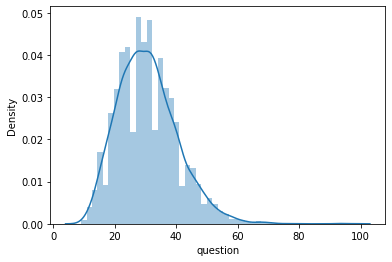

In [20]:
sns.distplot(finance_questions_df["question"].map(len))

In [21]:
def single_s_search(s, tables, meta_table = db["finance_meta"]):
    true_table_id = s.table_id
    question = s.question.strip() 
    
    qs_df = pd.DataFrame([[question]], columns = ["question"])
    true_table = get_table(tables, "Table_{}".format(true_table_id))
    true_pd_df = retrieve_table_in_pd_format(meta_table, true_table)
    true_tableqa_df = full_before_cat_decomp(true_pd_df, qs_df, only_req_columns=False)
    true_tableqa_df["name"] = "Table_{}".format(true_table_id)
    
    search_order_table_names = search_question(question, meta_table)
    req = []
    for tname, table in map(lambda tname: (tname, get_table(tables, tname)), search_order_table_names):
        pd_df = retrieve_table_in_pd_format(meta_table, table)
        qs_df = pd.DataFrame([[question]], columns = ["question"])
        tableqa_df = full_before_cat_decomp(pd_df, qs_df, only_req_columns=False)
        tableqa_df["name"] = tname
        req.append(tableqa_df)
    
    return (true_tableqa_df, pd.concat(req, axis = 0))

In [22]:
def extract_special_header_string(meta_table):
    meta_df = pd.DataFrame(meta_table.rows)
    #### header startwith 0-9 and all chinese header are dropout
    #### these headers are contain some special string in it
    special_header_set = set(filter(lambda x: "".join(template_extractor([(x,)])) != x and not any(map(lambda n: x.startswith(str(n)), range(10))),reduce(lambda a, b: a.union(b) ,meta_df["header"].map(eval).map(set).tolist())))
    #### this extract all chinese part from special_header_set and union with original only chinese header
    special_header_set_chinese_part = set(filter(lambda _:_ ,set(map(lambda x: "".join(template_extractor([(x,)])), special_header_set)).union(set(filter(lambda x: "".join(template_extractor([(x,)])) == x and not any(map(lambda n: x.startswith(str(n)), range(10))),reduce(lambda a, b: a.union(b) ,meta_df["header"].map(eval).map(set).tolist()))))))
    special_header_set_res_part = set(filter(lambda c: all(map(lambda sp: sp not in c, special_header_set_chinese_part)), special_header_set))
    not_match_tokens = set([
     '业务量','关联A股','净买入股份数合计','初始融资规模上限','周成交','周成交量',
        '商誉', '净利润', '净资产', '成交量','扩产产能','投资额', '注册证','备案数量',
'流通A股','股份','解禁前流通A股','解禁数量','货币资金','总资产','预计商誉减值上限','（%）']
    )
    special_header_set_en_part = set(filter(lambda c: all(map(lambda sp: sp not in c, not_match_tokens)), special_header_set_res_part))
    special_header_set_chinese_part = special_header_set_chinese_part.union(not_match_tokens).difference(set(['（%）']))
    
    return special_header_set_chinese_part ,special_header_set_en_part

In [23]:
sp_zh, sp_en = extract_special_header_string(db["finance_meta"])

In [24]:
en_sp_tks = ('PB','PE','PS','PEG','P/B','EPS','ROE','NAV','RNAV','CAGR','P/NAV','RNAVP','P/R-V','PETTM','P/RNAV',) + \
("P/E","TTM","ROA","yield","P/E(x)","PE（X）","EVEBITDA" )

In [25]:
zh_sp_tks = ('代码', '指标股份', '评级', '变动收益', '占比', '估值', '增速', '售价', '现价', '期限环比', '股东', '企业', '城市', '溢价', '公司', '市值', '银行', '证券', '涨跌', '收盘', '标的', '涨股', '区域', '省份', '涨幅', '运距', '商誉', '股价', '跌幅', '行业', '同比', '开盘',) +\
('折溢价', '净资产', '跌股票', '股代码', '增长率', '总市值', '业务量', '子行业', '目标价', '股息率', '总股本', '年利率', '周涨跌', '投资额', '成交量', '折价率', '月涨幅', '新三板', '收盘价', '总资产', '市净率', '手股份', '溢价率', '公告日', '涨跌幅', '流通股', '周涨幅', '股价格', '倒挂率', '净利率', '市盈率', '折现率', '注册证', '净利润', '收益率', '最新价', '关联股', '周成交', '楼面价', ) + \
('财报时间', '土地储备', '货币资金', '解禁数量', '跌股代码', '涨股代码', '持股比例', '成交量股', '关联A股', '市值比重', '成交宗数', '上市银行', '流通A股', '增发目的', '同比增速', '股东名称', '权益地价', '重点公司', '证券简称', '亿元市值', '总地面积', '成交均价', '评级类别', '评级变动', '建设周期', '募资项目', '上市时间', '成交面积', '增发价格', '上市日期', '周换手率', '变动次数', '所占比例', '成交股票', '模拟组合', '营业收入', '定增年度', '所处领域', '当前股价', '元目标价', '营收同比', '股票简称', '股票名称', '主要业务', '公司简称', '解禁日期', '短期评级', '降价幅度', '公司名称', '股票代码', '城市名称', '投资时间', '亿元商誉', '建筑面积', '上市地点', '所属行业', '股权占比', '元股价格', '年度项目', '涨股名称', '路产名称', '累计涨幅', '解禁收益', '月涨跌幅', '国家地区', '注册地址', '投资评级', '公司代码', '公司全称', '跌股名称', '股溢价率', '证券代码', '最新评级', '持股数量', '涨幅排名', '同比涨跌', '扩产产能', '证券名称', '当前市值', '跌幅排名', '指数代码', '挂牌时间', '备案数量', '周成交量', '亿投资额', '上涨股票', '最新股价', '元收盘价', '权益乘数', '换手股票', '下跌股票', '年涨跌幅', '周涨跌幅')

In [26]:
def produce_token_dict(token_set, special_tokens = ("",)):
    req = defaultdict(set)
    for tk in token_set:
        for sp_tk in special_tokens:
            if sp_tk in tk:
                req[sp_tk].add(tk)
    return dict(req)

In [27]:
en_sp_dict = produce_token_dict(sp_en, en_sp_tks)
zh_sp_dict = produce_token_dict(sp_zh, zh_sp_tks)

In [28]:
def res_match_by_dict(res, sp_dict):
    sp_df = pd.DataFrame(reduce(lambda a, b: a + b ,map(lambda t2: list(map(lambda v: (t2[0], v) ,t2[1])), sp_dict.items())))
    sp_df.columns = ["k", "v"]
    sp_df["k_len"] = sp_df["k"].map(len)
    sp_df["v_len"] = sp_df["v"].map(len)
    sp_df["k_common_len"] = sp_df["k"].map(lambda v: len(findMaxSubString(res, v)))
    sp_df["v_common_len"] = sp_df["v"].map(lambda v: len(findMaxSubString(res, v)))
    sp_df["k_common_ratio"] = sp_df.apply(lambda s: s.k_common_len / (s.k_len + 1), axis = 1)
    sp_df["v_common_ratio"] = sp_df.apply(lambda s: s.v_common_len / (s.v_len + 1), axis = 1)
    return sp_df.sort_values(by = ["v_common_len", "k_common_len"], ascending=False)

In [29]:
def guess_most_match(sp_df):
    #ic(np.max(sp_df[["k_common_ratio", "v_common_ratio"]].values))
    max_val = np.max(sp_df[["k_common_ratio", "v_common_ratio"]].values)
    if max_val <= 0:
        return None
    rows, columns = np.where(sp_df[["k_common_ratio", "v_common_ratio"]].values == max_val)
    #ic(rows, columns)
    first = list(zip(rows.tolist(), columns.tolist()))[0]
    return sp_df.iloc[first]

In [30]:
def calculate_sim_score_on_s(s):
    question_column = s.question_column
    if question_column is None:
        return 0
    header = s.header.split(",")
    total_conds_filtered = s.total_conds_filtered
    question = s.question.strip()
    total_conds_filtered_t2 = list(map(lambda t3: [str(t3[0]), str(t3[2])], total_conds_filtered))
    if total_conds_filtered_t2 and total_conds_filtered_t2[0]:
        total_conds_filtered_t2 = reduce(lambda a, b: a + b, total_conds_filtered_t2)
    else:
        total_conds_filtered_t2 = []
    zh_match_list = list(map(lambda res: guess_most_match(res_match_by_dict(res, zh_sp_dict)), [question_column] + total_conds_filtered_t2))
    en_match_list = list(map(lambda res: guess_most_match(res_match_by_dict(res, en_sp_dict)), [question_column] + total_conds_filtered_t2))

    match_list = list(filter(lambda m: 1 if m in header and m in [question_column] + total_conds_filtered_t2 else 0 , filter(lambda x: type(x) == type("") ,zh_match_list + en_match_list)))

    if not match_list:
        return 0
    match_conn_toks = reduce(lambda a, b: a + b ,map(lambda m: list(jieba.cut(m)), match_list)) 
    question_toks = list(jieba.cut(question))

    bm25 = BM25Okapi([match_conn_toks])
    doc_scores = bm25.get_scores(question_toks)
    bm25_score = np.abs(doc_scores.reshape([-1])[0])
    return bm25_score

In [31]:
def score_sum(s, weight = 0.5):
    if s.score_tuple[0] == 0:
        return 0
    return weight * sum(s.score_tuple) + (1 - weight) * s.qst_header_search_score

In [32]:
def resort_by_score_sum(df, weight = 0.5):
    sum_s = df.apply(lambda s: score_sum(s, weight), axis = 1).values
    return df.iloc[np.argsort(sum_s)][::-1]

In [33]:
##### use percentile to have a composite sort among all scores.
#### this make sense to all other kinds scores (combine discrete 0-1 and continous bm25 is different score range),
#### and have a relative high recall.
#### if the score distribute more seperate, the conclusion is more accurate,
def percentile_sort(df, perc_num = 101):
    score_tuple_s = df["score_tuple"]
    qst_header_search_score_s = df["qst_header_search_score"]
    #ic(score_tuple_s.head())
    #ic(qst_header_search_score_s.head())
    score_array = np.concatenate([np.asarray(score_tuple_s.values.tolist()).reshape((-1, 5)), qst_header_search_score_s.values.reshape((-1, 1))], axis = 1)
    perc_list = np.linspace(0, 100, perc_num).tolist()
    low_to_high_perc_array = np.stack(list(map(lambda p: np.percentile(score_array, p, axis = 0), perc_list)))
    
    def get_rank(array_):
        lookup_list = pd.DataFrame(array_ - low_to_high_perc_array[::-1]).apply(lambda s: min(s) >= 0, axis = 1).tolist()
        if True not in lookup_list:
            return len(lookup_list)
        return lookup_list.index(True)
    
    rank_list = []
    for i in range(score_array.shape[0]):
        rank_list.append(get_rank(score_array[i, :]))
    
    rank_s = pd.Series(rank_list)
    return df.iloc[np.argsort(rank_s.values)] 

In [34]:
##### this score only valid without fit data, after engine-map register
### should add a fit data score to evaluate the conclusion
def sort_search_tableqa_df(search_tableqa_df, meta_table, t5_order = [0, 1, 2, 3, 4]):
    search_tableqa_df = search_tableqa_df.copy()
    sort_order_list = [
        "question_column", 
        "total_conds_filtered",
        "agg_pred",
        "conn_pred",
    ]
    sort_func_list = [
        lambda x: 1 if type(x) == type("") else 0,
        len,
        lambda x: 1 if x else 0,
        lambda x: 1 if x.strip() in ("and", "or") else 0                 
    ]
    
    search_tableqa_df["qa_score_tuple"] = search_tableqa_df.apply(lambda s: list(map(lambda idx_and_val:sort_func_list[idx_and_val[0]](idx_and_val[1]) ,enumerate(s.loc[sort_order_list].tolist()))), axis = 1).map(tuple)
    
    search_part_df = search_tableqa_df[["question", "name"]].copy()
    
    meta_df = pd.DataFrame(meta_table.rows)
    def get_all_text_str_elements(tname):
        return meta_df[meta_df.name == tname].iloc[0].loc["all_text_str_elements"]
    
    def tokenize(question, drop_tags = ("x",)):
        question_token_connected = " ".join(map(lambda ttt2: ttt2[0] ,filter(lambda tt2: tt2[1] not in drop_tags ,map(lambda t2: (t2.word, t2.flag) ,posseg.cut(question)))))
        question_token_connected = " ".join(template_extractor([(question_token_connected,)]))
        return question_token_connected
        
    def calculate_bm25(text0, text1):
        if (not text0.strip()) or (not text1.strip()):
            return 0
        tokenized_corpus = [text0.split(" ")]
        bm25 = BM25Okapi(tokenized_corpus)
        query = text1
        tokenized_query = query.split(" ")
        doc_scores = bm25.get_scores(tokenized_query)
        return np.abs(doc_scores.reshape([-1])[0])
    
    search_part_df["all_text_str_elements"] = search_part_df["name"].apply(get_all_text_str_elements)
    
    bm25_score_list = search_part_df.apply(lambda s: calculate_bm25(tokenize(s.question), s.all_text_str_elements), axis = 1).tolist()
    search_tableqa_df["search_score"] = bm25_score_list
    
    ##### default score tuple order, in decrease order.
    ### (bool("question_column"), search_score, len("total_conds_filtered"), bool("agg_pred"), len("conn_pred"),)
    search_tableqa_df["score_tuple"] = search_tableqa_df.apply(lambda s: (s.qa_score_tuple[0],) + (s.search_score,) + s.qa_score_tuple[1:], axis = 1).map(lambda x: np.asarray(x)[t5_order]).map(lambda x: x.tolist()).map(tuple)
    
    search_tableqa_df["qst_header_search_score"] = search_tableqa_df.apply(calculate_sim_score_on_s, axis = 1)
    
    return search_tableqa_df

In [35]:
def single_question_search(question, tables, meta_table = db["finance_meta"], 
                           add_search_score = True, 
                            t5_order = [0, 1, 2, 3, 4],
                          ori_alias_mapping = dict(),
                          drop_cond_qst_contain = True,
                          ):    
    search_order_table_names = search_question(question, meta_table)
    req = []
    for tname, table in map(lambda tname: (tname, get_table(tables, tname)), search_order_table_names):
        if table is not None:
            pd_df = retrieve_table_in_pd_format(meta_table, table, ori_alias_mapping)
            qs_df = pd.DataFrame([[question]], columns = ["question"])
            tableqa_df = full_before_cat_decomp(pd_df, qs_df, only_req_columns=False)
            tableqa_df["name"] = tname
            req.append(tableqa_df)
    
    search_tableqa_df = pd.concat(req, axis = 0)
    if drop_cond_qst_contain:
        search_tableqa_df = search_tableqa_df[search_tableqa_df.apply(lambda s: s.question_column not in map(lambda t3: t3[0], s.total_conds_filtered), axis = 1)]
    
    if add_search_score:
        return sort_search_tableqa_df(search_tableqa_df, meta_table, t5_order).sort_values(by = "score_tuple", ascending = False)
    
    return search_tableqa_df

In [36]:
true_tableqa_df, search_tableqa_df =  single_s_search(finance_questions_df.iloc[0], finance_tables)

In [37]:
first_question_search_df = single_question_search(finance_questions_df.iloc[0]["question"], finance_tables)

In [39]:
percentile_sort(first_question_search_df).head(2)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,conn_pred,total_conds,total_conds_filtered,question_column_qst,question_column,name,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,成交楼面均价小于1000的规划建筑面积是多少,"([], 的规划建筑面积是多少, 成交楼面均价小于1000)",[],"([(成交楼面均价, <, 1000)], 的规划建筑面积是多少, )","[ , 成交, 楼面, 均价, 小于, 1000, 的, 规划, 建筑面积, 是, 多少]","城市,推出土地宗数,推出建设用地,成交土地宗数,成交建设用地,成交规划建筑面积,成交均价,平...",成交规划建筑面积,0,0,,...,,"[(成交楼面均价, <, 1000)]","[(成交均价, <, 1000)]",成交规划建筑面积,成交规划建筑面积,Table_252d21fd302e11e9985f542696d6e445,"(1, 1, 0, 0)",1.922572,"(1.0, 1.9225715051691912, 1.0, 0.0, 0.0)",1.216321
0,成交楼面均价小于1000的规划建筑面积是多少,"([], 的规划建筑面积是多少, 成交楼面均价小于1000)",[],"([(成交楼面均价, <, 1000)], 的规划建筑面积是多少, )","[ , 成交, 楼面, 均价, 小于, 1000, 的, 规划, 建筑面积, 是, 多少]","300城市土地出让,规划建筑面积(万㎡),成交楼面均价(元/㎡),平均溢价率(%),土地出让...",规划建筑面积(万㎡),0,0,,...,,"[(成交楼面均价, <, 1000)]","[(成交楼面均价(元/㎡), <, 1000)]",规划建筑面积(万㎡),规划建筑面积(万㎡),Table_43ad6bdc1d7111e988a6f40f24344a08,"(1, 1, 0, 0)",1.373265,"(1.0, 1.3732653608351366, 1.0, 0.0, 0.0)",0.000000


In [40]:
finance_questions_df.iloc[0]["question"]

' 成交楼面均价小于1000的规划建筑面积是多少'

In [41]:
##### question also make sense in this table, although is not the truly table. (top1)
retrieve_table_in_pd_format(db["finance_meta"], get_table(finance_tables, "Table_252d21fd302e11e9985f542696d6e445"))

,城市,推出土地宗数,推出建设用地,成交土地宗数,成交建设用地,成交规划建筑面积,成交均价,平均溢价率
0,北京,0.0,0.0,0.0,0.0,0,0.0,0.0
1,天津,1.0,27541.0,2.0,66813.0,100220,527.0,0.0
2,济南,0.0,0.0,0.0,0.0,0,0.0,0.0
3,青岛,0.0,0.0,0.0,0.0,0,0.0,0.0
4,大连,0.0,0.0,3.0,246753.0,551203,3477.0,0.0
5,哈尔滨,0.0,0.0,0.0,0.0,0,0.0,0.0
6,上海,3.0,94282.0,0.0,0.0,0,0.0,0.0
7,苏州,1.0,105462.0,0.0,0.0,0,0.0,0.0
8,南京,2.0,89816.0,0.0,0.0,0,0.0,0.0
9,徐州,0.0,0.0,0.0,0.0,0,0.0,0.0


In [42]:
##### truly table for first question. (top2)
retrieve_table_in_pd_format(db["finance_meta"], get_table(finance_tables, "Table_43ad6bdc1d7111e988a6f40f24344a08"))

,300城市土地出让,规划建筑面积(万㎡),成交楼面均价(元/㎡),平均溢价率(%),土地出让金(亿元),同比
0,2009年7月-2010年6月,168212.0,1173.0,40.0,20056.0,None
1,2010年7月-2011年6月,237405.0,1040.0,21.0,24897.0,24.0
2,2011年7月-2012年6月,199533.0,910.0,6.0,18479.0,-26.0
3,2012年7月-2013年6月,244512.0,1037.0,12.0,25750.0,39.0
4,2013年7月-2014年6月,250637.0,1260.0,15.0,32061.0,25.0
5,2014年7月-2015年6月,150515.0,1246.0,9.0,18885.0,-41.0
6,2015年7月-2016年6月,155643.0,1567.0,28.0,24738.0,31.0
7,2016年7月-2017年6月,151707.0,2202.0,41.0,33542.0,36.0
8,2017年7月-2018年6月,189395.0,2368.0,23.0,44854.0,34.0
9,2018年7月-2019年6月E,198865.0,2113.0,None,42020.0,-6.0


In [43]:
only_kws_columns

{'城市': '=='}

In [44]:
only_kws_columns["简称"] = "=="

In [45]:
only_kws_columns

{'城市': '==', '简称': '=='}

In [46]:
#### this case like "城市" in estate data
question = "光大证券的股价2018/12/28是多少？"
#input_tables = list(filter(lambda t: t.name == order_table_names[0], finance_tables))
input_tables = finance_tables
second_question_search_df = single_question_search(question, input_tables, t5_order = [0, 1, 2, 3, 4])

In [47]:
second_question_search_df.head(2)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,conn_pred,total_conds,total_conds_filtered,question_column_qst,question_column,name,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,光大证券的股价2018/12/28是多少？,"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )","[(简称, ==, 光大证券)]","([(证券, ==, 光大)], 的股价2018/12/28是多少？, )","[光大, 证券, 的, 股价, 2018, /, 12, /, 28, 是, 多少, ？]","简称,股票代码,所属行业,评级,股价2018/12/28,EPS17A,EPS18E,EPS...",股价2018/12/28,0,0,,...,,"[(股价, ==, 光大), (证券, ==, 光大), (简称, ==, 光大证券)]","[(简称, ==, 光大证券)]",股价2018/12/28,股价2018/12/28,Table_e0ac35f8333a11e99688542696d6e445,"(1, 1, 0, 0)",3.021184,"(1.0, 3.0211837938373005, 1.0, 0.0, 0.0)",0.0
0,光大证券的股价2018/12/28是多少？,"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )",[],"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )","[光大, 证券, 的, 股价, 2018, /, 12, /, 28, 是, 多少, ？]","证券代码,证券简称,评级,最新价,EPS11A,EPS12E,EPS13E,EPS14E,P...",PE12E,0,0,,...,,"[(股价, ==, 光大), (证券, ==, 光大)]",[],PE12E,PE12E,Table_5a4daa47312b11e9923a542696d6e445,"(1, 0, 0, 0)",1.373265,"(1.0, 1.3732653608351366, 0.0, 0.0, 0.0)",0.0


In [49]:
#### add fit score
percentile_sort(second_question_search_df).head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,conn_pred,total_conds,total_conds_filtered,question_column_qst,question_column,name,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,光大证券的股价2018/12/28是多少？,"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )",[],"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )","[光大, 证券, 的, 股价, 2018, /, 12, /, 28, 是, 多少, ？]","证券代码,证券简称,公告日,内容",None,0,0,,...,,"[(股价, ==, 光大), (证券, ==, 光大)]",[],证券简称,证券简称,Table_4d2537213aaa11e98a68f40f24344a08,"(1, 0, 0, 0)",1.098612,"(1.0, 1.0986122886681093, 0.0, 0.0, 0.0)",0.274653
0,光大证券的股价2018/12/28是多少？,"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )",[],"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )","[光大, 证券, 的, 股价, 2018, /, 12, /, 28, 是, 多少, ？]","证券代码,证券简称,最新市值（亿港币）,最新股价,本周涨幅前十",最新股价,0,0,,...,,"[(股价, ==, 光大), (证券, ==, 光大)]",[],最新股价,最新股价,Table_5a50942e312b11e99d48542696d6e445,"(1, 0, 0, 0)",1.098612,"(1.0, 1.0986122886681093, 0.0, 0.0, 0.0)",0.274653
0,光大证券的股价2018/12/28是多少？,"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )",[],"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )","[光大, 证券, 的, 股价, 2018, /, 12, /, 28, 是, 多少, ？]","证券代码,证券简称,最新市值（亿港币）,最新股价,本周跌幅后十",最新股价,0,0,,...,,"[(股价, ==, 光大), (证券, ==, 光大)]",[],最新股价,最新股价,Table_e0ae228c333a11e9abc0542696d6e445,"(1, 0, 0, 0)",1.098612,"(1.0, 1.0986122886681093, 0.0, 0.0, 0.0)",0.274653
0,光大证券的股价2018/12/28是多少？,"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )",[],"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )","[光大, 证券, 的, 股价, 2018, /, 12, /, 28, 是, 多少, ？]","证券代码,证券简称,最新市值（亿港币）,最新股价,本周跌幅后十",最新股价,0,0,,...,,"[(股价, ==, 光大), (证券, ==, 光大)]",[],最新股价,最新股价,Table_e0ac70f3333a11e9903e542696d6e445,"(1, 0, 0, 0)",1.098612,"(1.0, 1.0986122886681093, 0.0, 0.0, 0.0)",0.274653
0,光大证券的股价2018/12/28是多少？,"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )",[],"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )","[光大, 证券, 的, 股价, 2018, /, 12, /, 28, 是, 多少, ？]","证券代码,证券简称,最新市值（亿港币）,最新股价,本周跌幅后十",最新股价,0,0,,...,,"[(股价, ==, 光大), (证券, ==, 光大)]",[],最新股价,最新股价,Table_e0aecbae333a11e99e03542696d6e445,"(1, 0, 0, 0)",1.098612,"(1.0, 1.0986122886681093, 0.0, 0.0, 0.0)",0.274653


In [50]:
retrieve_table_in_pd_format(db["finance_meta"], get_table(finance_tables, "Table_4d24dafd3aaa11e99105f40f24344a08"))

,证券代码,证券简称,净利润上限（亿元）,净利润下限（亿元）,净利润增速上限（%）,净利润增速下限（%）
0,安妮股份,002235.SZ,1.30,0.80,135.61,121.91
1,皇氏集团,002329.SZ,5.70,6.50,1104.58,1245.58
2,盛通股份,002599.SZ,1.50,1.20,62.08,29.67
3,易尚展示,002751.SZ,1.00,0.80,110.57,68.46
4,东方网络,002175.SZ,4.10,4.90,50.74,80.15
5,平治信息,300571.SZ,2.35,2.06,142.20,112.31


In [51]:
retrieve_table_in_pd_format(db["finance_meta"], get_table(finance_tables, "Table_e0ac35f8333a11e99688542696d6e445"))

,简称,股票代码,所属行业,评级,股价2018/12/28,EPS17A,EPS18E,EPS19E,PE17A,PE18E,PE19E,收益率
0,中信证券,600030.SH,证券Ⅱ,买入,16.01,0.94,0.84,0.99,17.0,19.0,16.0,1.27
1,海通证券,600837.SH,证券Ⅱ,增持,8.80,0.75,0.45,0.57,12.0,20.0,16.0,0.86
2,广发证券,000776.SZ,证券Ⅱ,增持,12.68,1.13,0.76,0.99,11.0,17.0,13.0,1.13
3,光大证券,601788.SH,证券Ⅱ,增持,8.77,0.65,0.35,0.41,13.0,25.0,21.0,0.83
4,招商证券,600999.SH,证券Ⅱ,增持,13.40,0.86,0.63,0.76,16.0,21.0,18.0,1.38
5,长江证券,000783.SZ,证券Ⅱ,增持,5.15,0.28,0.15,0.18,18.0,34.0,29.0,1.09
6,东方证券,600958.SH,证券Ⅱ,增持,7.97,0.51,0.28,0.38,16.0,28.0,21.0,1.08
7,兴业证券,601377.SH,证券Ⅱ,增持,4.64,0.29,0.17,0.25,16.0,28.0,19.0,0.94


In [52]:
question = "光大证券的股价是多少？"
#### add alias by copy column in retrieve_table_in_pd_format dynamic in memory (not in db)
#input_tables = list(filter(lambda t: t.name == order_table_names[0], finance_tables))
input_tables = finance_tables
second_question_search_df = single_question_search(question, input_tables, t5_order = [0, 1, 2, 3, 4],
                                                  ori_alias_mapping = {"股价2018/12/28": "股价"})

In [54]:
second_question_search_df.head(2)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,conn_pred,total_conds,total_conds_filtered,question_column_qst,question_column,name,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,光大证券的股价是多少？,"([(证券, ==, 光大)], 的股价是多少？, )","[(简称, ==, 光大证券)]","([(证券, ==, 光大)], 的股价是多少？, )","[光大, 证券, 的, 股价, 是, 多少, ？]","简称,股票代码,所属行业,评级,股价2018/12/28,EPS17A,EPS18E,EPS...",股价,0,0,,...,,"[(证券, ==, 光大), (简称, ==, 光大证券)]","[(简称, ==, 光大证券)]",股价,股价,Table_e0ac35f8333a11e99688542696d6e445,"(1, 1, 0, 0)",3.021184,"(1.0, 3.0211837938373005, 1.0, 0.0, 0.0)",0.274653
0,光大证券的股价是多少？,"([(证券, ==, 光大)], 的股价是多少？, )",[],"([(证券, ==, 光大)], 的股价是多少？, )","[光大, 证券, 的, 股价, 是, 多少, ？]","证券代码,证券简称,评级,最新价,EPS11A,EPS12E,EPS13E,EPS14E,P...",最新价,0,0,,...,,"[(证券, ==, 光大)]",[],最新价,最新价,Table_5a4daa47312b11e9923a542696d6e445,"(1, 0, 0, 0)",1.373265,"(1.0, 1.3732653608351366, 0.0, 0.0, 0.0)",0.000000


In [56]:
percentile_sort(second_question_search_df).head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,conn_pred,total_conds,total_conds_filtered,question_column_qst,question_column,name,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,光大证券的股价是多少？,"([(证券, ==, 光大)], 的股价是多少？, )","[(简称, ==, 光大证券)]","([(证券, ==, 光大)], 的股价是多少？, )","[光大, 证券, 的, 股价, 是, 多少, ？]","简称,股票代码,所属行业,评级,股价2018/12/28,EPS17A,EPS18E,EPS...",股价,0,0,,...,,"[(证券, ==, 光大), (简称, ==, 光大证券)]","[(简称, ==, 光大证券)]",股价,股价,Table_e0ac35f8333a11e99688542696d6e445,"(1, 1, 0, 0)",3.021184,"(1.0, 3.0211837938373005, 1.0, 0.0, 0.0)",0.274653
0,光大证券的股价是多少？,"([(证券, ==, 光大)], 的股价是多少？, )",[],"([(证券, ==, 光大)], 的股价是多少？, )","[光大, 证券, 的, 股价, 是, 多少, ？]","证券简称,证券代码,股价,总市值（亿元）,流通市值（亿元）,EPS17A,EPS18E,EP...",股价,0,0,,...,,"[(证券, ==, 光大)]",[],股价,股价,Table_4d28a13a3aaa11e98590f40f24344a08,"(1, 0, 0, 0)",1.373265,"(1.0, 1.3732653608351366, 0.0, 0.0, 0.0)",0.274653
0,光大证券的股价是多少？,"([(证券, ==, 光大)], 的股价是多少？, )",[],"([(证券, ==, 光大)], 的股价是多少？, )","[光大, 证券, 的, 股价, 是, 多少, ？]","证券简称,证券代码,股价,总市值（亿元）,流通市值（亿元）,EPS17A,EPS18E,EP...",股价,0,0,,...,,"[(证券, ==, 光大)]",[],股价,股价,Table_4d28b0303aaa11e9bd3ef40f24344a08,"(1, 0, 0, 0)",1.373265,"(1.0, 1.3732653608351366, 0.0, 0.0, 0.0)",0.274653
0,光大证券的股价是多少？,"([(证券, ==, 光大)], 的股价是多少？, )",[],"([(证券, ==, 光大)], 的股价是多少？, )","[光大, 证券, 的, 股价, 是, 多少, ？]","证券简称,证券代码,股价,总市值（亿元）,流通市值（亿元）,EPS17A,EPS18E,EP...",股价,0,0,,...,,"[(证券, ==, 光大)]",[],股价,股价,Table_4d2896e13aaa11e9a11df40f24344a08,"(1, 0, 0, 0)",1.373265,"(1.0, 1.3732653608351366, 0.0, 0.0, 0.0)",0.274653
0,光大证券的股价是多少？,"([(证券, ==, 光大)], 的股价是多少？, )",[],"([(证券, ==, 光大)], 的股价是多少？, )","[光大, 证券, 的, 股价, 是, 多少, ？]","证券简称,证券代码,股价,总市值（亿元）,流通市值（亿元）,EPS17A,EPS18E,EP...",股价,0,0,,...,,"[(证券, ==, 光大)]",[],股价,股价,Table_4d2879803aaa11e9ae5bf40f24344a08,"(1, 0, 0, 0)",1.373265,"(1.0, 1.3732653608351366, 0.0, 0.0, 0.0)",0.274653


In [57]:
second_question_search_df.sort_values(by = "qst_header_search_score", ascending = False).head(2)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,conn_pred,total_conds,total_conds_filtered,question_column_qst,question_column,name,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,光大证券的股价是多少？,"([(证券, ==, 光大)], 的股价是多少？, )","[(简称, ==, 光大证券)]","([(证券, ==, 光大)], 的股价是多少？, )","[光大, 证券, 的, 股价, 是, 多少, ？]","简称,股票代码,所属行业,评级,股价2018/12/28,EPS17A,EPS18E,EPS...",股价,0,0,,...,,"[(证券, ==, 光大), (简称, ==, 光大证券)]","[(简称, ==, 光大证券)]",股价,股价,Table_e0ac35f8333a11e99688542696d6e445,"(1, 1, 0, 0)",3.021184,"(1.0, 3.0211837938373005, 1.0, 0.0, 0.0)",0.274653
0,光大证券的股价是多少？,"([(证券, ==, 光大)], 的股价是多少？, )",[],"([(证券, ==, 光大)], 的股价是多少？, )","[光大, 证券, 的, 股价, 是, 多少, ？]","证券代码,名称,收盘价,目标价（元）,EPS(元)17A,EPS(元)18E,EPS(元)1...",None,0,0,,...,,"[(证券, ==, 光大)]",[],证券代码,证券代码,Table_43ade7071d7111e9a4b0f40f24344a08,"(1, 0, 0, 0)",1.098612,"(1.0, 1.0986122886681093, 0.0, 0.0, 0.0)",0.274653


In [58]:
question = "哪些股票的收盘价大于20？"
input_tables = finance_tables
question_search_df = single_question_search(question, input_tables, t5_order = [0, 1, 2, 3, 4])

In [60]:
question_search_df.head(2)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,conn_pred,total_conds,total_conds_filtered,question_column_qst,question_column,name,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,哪些股票的收盘价大于20？,"([(收盘价, >, 20)], 哪些股票的？, )",[],"([(收盘价, >, 20)], 哪些股票的？, )","[哪些, 股票, 的, 收盘价, 大于, 20, ？]","成交股票,成交收盘价,成交涨跌幅,成交量（万手）,成交额（亿元）,换手股票,换手收盘价,涨跌...",换手股票,0,0,,...,,"[(收盘价, >, 20)]","[(换手收盘价, >, 20)]",换手股票,换手股票,Table_43ae9d611d7111e9bf19f40f24344a08,"(1, 1, 0, 0)",1.098612,"(1.0, 1.0986122886681096, 1.0, 0.0, 0.0)",0.549306
0,哪些股票的收盘价大于20？,"([(收盘价, >, 20)], 哪些股票的？, )",[],"([(收盘价, >, 20)], 哪些股票的？, )","[哪些, 股票, 的, 收盘价, 大于, 20, ？]","上涨股票,涨幅%,下跌股票,跌幅%",下跌股票,0,0,,...,,"[(收盘价, >, 20)]",[],下跌股票,下跌股票,Table_4d27b9ab3aaa11e9951ef40f24344a08,"(1, 0, 0, 0)",1.098612,"(1.0, 1.0986122886681096, 0.0, 0.0, 0.0)",0.274653


In [61]:
### more high in recall
percentile_sort(question_search_df).head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,conn_pred,total_conds,total_conds_filtered,question_column_qst,question_column,name,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,哪些股票的收盘价大于20？,"([(收盘价, >, 20)], 哪些股票的？, )",[],"([(收盘价, >, 20)], 哪些股票的？, )","[哪些, 股票, 的, 收盘价, 大于, 20, ？]","成交股票,成交收盘价,成交涨跌幅,成交量（万手）,成交额（亿元）,换手股票,换手收盘价,涨跌...",换手股票,0,0,,...,,"[(收盘价, >, 20)]","[(换手收盘价, >, 20)]",换手股票,换手股票,Table_43ae9d611d7111e9bf19f40f24344a08,"(1, 1, 0, 0)",1.098612,"(1.0, 1.0986122886681096, 1.0, 0.0, 0.0)",0.549306
0,哪些股票的收盘价大于20？,"([(收盘价, >, 20)], 哪些股票的？, )",[],"([(收盘价, >, 20)], 哪些股票的？, )","[哪些, 股票, 的, 收盘价, 大于, 20, ？]","涨股,涨股收盘价,涨幅,跌股票,跌股收盘价,跌幅",跌股票,0,0,,...,,"[(收盘价, >, 20)]","[(跌股收盘价, >, 20)]",跌股票,跌股票,Table_43ae8f941d7111e98e72f40f24344a08,"(1, 1, 0, 0)",0.823959,"(1.0, 0.8239592165010822, 1.0, 0.0, 0.0)",0.549306
0,哪些股票的收盘价大于20？,"([(收盘价, >, 20)], 哪些股票的？, )",[],"([(收盘价, >, 20)], 哪些股票的？, )","[哪些, 股票, 的, 收盘价, 大于, 20, ？]","股票代码,股票简称,总市值（亿元）,市盈率(TTM),EPS(TTM),本周收盘价,一周涨跌...",股票简称,0,0,,...,,"[(收盘价, >, 20)]","[(本周收盘价, >, 20)]",股票简称,股票简称,Table_4d26e6303aaa11e9932df40f24344a08,"(1, 1, 0, 0)",0.549306,"(1.0, 0.5493061443340548, 1.0, 0.0, 0.0)",0.549306
0,哪些股票的收盘价大于20？,"([(收盘价, >, 20)], 哪些股票的？, )",[],"([(收盘价, >, 20)], 哪些股票的？, )","[哪些, 股票, 的, 收盘价, 大于, 20, ？]","上市银行,代码,收盘价,流通市值(亿元),P/E18E,P/E19E,ROAE18E,ROA...",股息收益率,0,0,,...,,"[(收盘价, >, 20)]","[(收盘价, >, 20)]",股息收益率,股息收益率,Table_e0ac1aa8333a11e9bd5e542696d6e445,"(1, 1, 0, 0)",0.549306,"(1.0, 0.5493061443340548, 1.0, 0.0, 0.0)",0.274653
0,哪些股票的收盘价大于20？,"([(收盘价, >, 20)], 哪些股票的？, )",[],"([(收盘价, >, 20)], 哪些股票的？, )","[哪些, 股票, 的, 收盘价, 大于, 20, ？]","股票代码,股票简称,总市值（亿元）,市盈率(TTM),EPS(TTM),本周收盘价,一周涨跌...",股票简称,0,0,,...,,"[(收盘价, >, 20)]","[(本周收盘价, >, 20)]",股票简称,股票简称,Table_4d26a0303aaa11e99111f40f24344a08,"(1, 1, 0, 0)",0.549306,"(1.0, 0.5493061443340548, 1.0, 0.0, 0.0)",0.549306


In [62]:
retrieve_table_in_pd_format(db["finance_meta"], get_table(finance_tables, "Table_43ae9d611d7111e9bf19f40f24344a08"))

,成交股票,成交收盘价,成交涨跌幅,成交量（万手）,成交额（亿元）,换手股票,换手收盘价,涨跌幅,周换手率
0,市北高新,7.71,5.8,85893.88,66.59,市北高新,7.71,5.8,64.4
1,万科A,23.82,-1.8,18174.21,43.31,亚太实业,4.58,-5.0,27.6
2,张江高科,14.95,7.9,24520.55,35.54,万方发展,5.55,-4.8,22.9
3,保利地产,11.79,-1.3,25442.70,30.11,中迪投资,5.25,-8.9,21.4
4,华夏幸福,25.45,-0.7,5550.60,13.95,实达集团,6.28,1.6,20.9
5,招商蛇口,17.35,2.1,6871.90,11.70,中润资源,2.69,-21.8,19.8
6,南京高科,7.88,0.8,12145.43,9.75,珠江实业,4.35,-2.0,19.6
7,银亿股份,3.12,-13.3,28747.33,9.41,华业资本,2.59,-7.5,18.3
8,新城控股,23.69,-1.9,3956.60,9.32,北汽蓝谷,7.96,-3.5,15.9
9,荣盛发展,7.95,-2.7,11186.29,8.98,张江高科,14.95,7.9,15.8


In [63]:
question = "市值的最大值是多少？"
input_tables = finance_tables
question_search_df = single_question_search(question, input_tables, t5_order = [0, 1, 2, 3, 4])

In [64]:
question_search_df.head(2)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,conn_pred,total_conds,total_conds_filtered,question_column_qst,question_column,name,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,市值的最大值是多少？,"([], None, )",[],"([], None, None)","[市值, 的, 最大值, 是, 多少, ？]","序号,证券代码,证券简称,子行业,2018Q3营收同比增速（%）,2017Y营收同比增速（%...",None,0,2,MAX,...,,[],[],市值,市值,Table_733d80fd34c611e98d98542696d6e445,"(1, 0, 1, 0)",0.549306,"(1.0, 0.5493061443340548, 0.0, 1.0, 0.0)",0.274653
0,市值的最大值是多少？,"([], None, )",[],"([], None, None)","[市值, 的, 最大值, 是, 多少, ？]","公司名称,股东权益价值（亿元）,出资额（亿元）,股权占比,出资额的货币资金占比*,出资额的归...",None,0,2,MAX,...,,[],[],股东权益价值（亿元）,股东权益价值（亿元）,Table_6e612f0f34ce11e9bf9c542696d6e445,"(1, 0, 1, 0)",0.549306,"(1.0, 0.5493061443340548, 0.0, 1.0, 0.0)",0.000000


In [65]:
percentile_sort(question_search_df).head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,conn_pred,total_conds,total_conds_filtered,question_column_qst,question_column,name,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,市值的最大值是多少？,"([], None, )",[],"([], None, None)","[市值, 的, 最大值, 是, 多少, ？]","序号,证券代码,证券简称,子行业,2018Q3营收同比增速（%）,2017Y营收同比增速（%...",None,0,2,MAX,...,,[],[],市值,市值,Table_733d80fd34c611e98d98542696d6e445,"(1, 0, 1, 0)",0.549306,"(1.0, 0.5493061443340548, 0.0, 1.0, 0.0)",0.274653
0,市值的最大值是多少？,"([], None, )",[],"([], None, None)","[市值, 的, 最大值, 是, 多少, ？]","序号,证券代码,证券简称,子行业,2018Q3营收同比增速（%）,2017Y营收同比增速（%...",None,0,2,MAX,...,,[],[],市值,市值,Table_733d8a0c34c611e98d5e542696d6e445,"(1, 0, 1, 0)",0.549306,"(1.0, 0.5493061443340548, 0.0, 1.0, 0.0)",0.274653
0,市值的最大值是多少？,"([], None, )",[],"([], None, None)","[市值, 的, 最大值, 是, 多少, ？]","序号,证券代码,证券简称,子行业,2018Q3营收同比增速（%）,2017Y营收同比增速（%...",None,0,2,MAX,...,,[],[],市值,市值,Table_733d74f334c611e9b31d542696d6e445,"(1, 0, 1, 0)",0.549306,"(1.0, 0.5493061443340548, 0.0, 1.0, 0.0)",0.274653
0,市值的最大值是多少？,"([], None, )",[],"([], None, None)","[市值, 的, 最大值, 是, 多少, ？]","模拟组合,持股数量（万股）,最新股价（元/股）,最新市值(百万元）,市值比重",None,0,2,MAX,...,,[],[],市值比重,市值比重,Table_5a4b72ab312b11e9a895542696d6e445,"(1, 0, 1, 0)",0.549306,"(1.0, 0.5493061443340548, 0.0, 1.0, 0.0)",0.274653
0,市值的最大值是多少？,"([], None, )",[],"([], None, None)","[市值, 的, 最大值, 是, 多少, ？]","模拟组合,持股数量（万股）,最新股价（元/股）,最新市值(百万元）,最新市值比重",None,0,2,MAX,...,,[],[],最新市值比重,最新市值比重,Table_252c1bcc302e11e9a40e542696d6e445,"(1, 0, 1, 0)",0.549306,"(1.0, 0.5493061443340548, 0.0, 1.0, 0.0)",0.274653


In [66]:
retrieve_table_in_pd_format(db["finance_meta"], get_table(finance_tables, "Table_733d74f334c611e9b31d542696d6e445"))

,序号,证券代码,证券简称,子行业,2018Q3营收同比增速（%）,2017Y营收同比增速（%）,2018Q3净利润同比增速（%）,2017Y净利润同比增速（%）,市值,市盈率,市净率,收益
0,1.0,JBHT.O,JB亨特运输服务,陆运,21.11,9.67,33.21,58.82,106.43,13.54,5.79,7.2000
1,2.0,ODFL.O,OLD-DOMINION,陆运,22.28,12.25,67.42,56.80,104.51,16.24,4.59,7.8700
2,3.0,LSTR.O,莱帝土地星,陆运,32.30,15.11,66.49,28.93,41.32,16.41,6.35,6.1238
3,4.0,SNDR.N,NATIONAL,陆运,14.50,8.35,73.68,148.50,35.90,7.67,1.90,2.6441
4,5.0,R.N,莱德物流,陆运,14.63,7.99,11.14,201.19,29.53,3.66,1.04,15.2020
5,6.0,WERN.O,沃纳企业,陆运,16.92,5.36,83.93,156.40,22.28,8.75,1.88,3.5778


In [68]:
retrieve_table_in_pd_format(db["finance_meta"], get_table(finance_tables, "Table_733d80fd34c611e98d98542696d6e445"))

,序号,证券代码,证券简称,子行业,2018Q3营收同比增速（%）,2017Y营收同比增速（%）,2018Q3净利润同比增速（%）,2017Y净利润同比增速（%）,市值,市盈率,市净率,收益
0,1.0,0177.HK,江苏宁沪高速公路,公路与铁路,8.52,4.00,26.11,7.23,570.27,11.55,2.03,0.86
1,2.0,0576.HK,浙江沪杭甬,公路与铁路,-0.52,-1.12,11.69,5.42,317.05,7.68,1.28,0.80
2,3.0,0548.HK,深圳高速公路股份,公路与铁路,13.20,7.44,30.43,21.98,188.64,9.32,1.16,0.82


In [69]:
##### can add conds validator to question, if this question should conds (with "大于" in it)
### then auto set t5_order to [0, 2, 1, 3, 4]
question = "EPS大于0的股票有哪些？"
input_tables = finance_tables
question_search_df = single_question_search(question, input_tables, t5_order = [0, 2, 1, 3, 4])

In [70]:
question_search_df.head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,conn_pred,total_conds,total_conds_filtered,question_column_qst,question_column,name,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,EPS大于0的股票有哪些？,"([(EPS, >, 0)], 的股票有哪些？, )",[],"([(EPS, >, 0)], 的股票有哪些？, )","[EPS, 大于, 0, 的, 股票, 有, 哪些, ？]","股票代码,股票简称,PE-TTM,PB,PS",股票简称,0,0,,...,,"[(EPS, >, 0)]","[(PS, >, 0)]",股票简称,股票简称,Table_43afe8f01d7111e99f11f40f24344a08,"(1, 1, 0, 0)",0.274653,"(1.0, 1.0, 0.2746530721670274, 0.0, 0.0)",0.274653
0,EPS大于0的股票有哪些？,"([(EPS, >, 0)], 的股票有哪些？, )",[],"([(EPS, >, 0)], 的股票有哪些？, )","[EPS, 大于, 0, 的, 股票, 有, 哪些, ？]","股票代码,股票简称,总市值（亿元）,市盈率(TTM),EPS(TTM),本周收盘价,一周涨跌...",股票简称,0,0,,...,,"[(EPS, >, 0)]","[(EPS(TTM), >, 0)]",股票简称,股票简称,Table_4d26e1a83aaa11e9987ef40f24344a08,"(1, 1, 0, 0)",0.274653,"(1.0, 1.0, 0.2746530721670274, 0.0, 0.0)",0.549306
0,EPS大于0的股票有哪些？,"([(EPS, >, 0)], 的股票有哪些？, )",[],"([(EPS, >, 0)], 的股票有哪些？, )","[EPS, 大于, 0, 的, 股票, 有, 哪些, ？]","股票代码,股票简称,周涨跌幅,PE-TTM,PB,PS,总市值(亿元）",股票简称,0,0,,...,,"[(EPS, >, 0)]","[(PS, >, 0)]",股票简称,股票简称,Table_43b2932b1d7111e9a434f40f24344a08,"(1, 1, 0, 0)",0.274653,"(1.0, 1.0, 0.2746530721670274, 0.0, 0.0)",0.274653
0,EPS大于0的股票有哪些？,"([(EPS, >, 0)], 的股票有哪些？, )",[],"([(EPS, >, 0)], 的股票有哪些？, )","[EPS, 大于, 0, 的, 股票, 有, 哪些, ？]","股票代码,股票简称,周涨跌幅,PE-TTM,PB,PS,总市值(亿元）",股票简称,0,0,,...,,"[(EPS, >, 0)]","[(PS, >, 0)]",股票简称,股票简称,Table_43b2b6a11d7111e9a211f40f24344a08,"(1, 1, 0, 0)",0.274653,"(1.0, 1.0, 0.2746530721670274, 0.0, 0.0)",0.274653
0,EPS大于0的股票有哪些？,"([(EPS, >, 0)], 的股票有哪些？, )",[],"([(EPS, >, 0)], 的股票有哪些？, )","[EPS, 大于, 0, 的, 股票, 有, 哪些, ？]","股票代码,股票简称,周涨跌幅,PE-TTM,PB,PS,总市值(亿人民币）",股票简称,0,0,,...,,"[(EPS, >, 0)]","[(PS, >, 0)]",股票简称,股票简称,Table_43b2d3d91d7111e9b7daf40f24344a08,"(1, 1, 0, 0)",0.274653,"(1.0, 1.0, 0.2746530721670274, 0.0, 0.0)",0.274653


In [71]:
percentile_sort(question_search_df).head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,conn_pred,total_conds,total_conds_filtered,question_column_qst,question_column,name,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,EPS大于0的股票有哪些？,"([(EPS, >, 0)], 的股票有哪些？, )",[],"([(EPS, >, 0)], 的股票有哪些？, )","[EPS, 大于, 0, 的, 股票, 有, 哪些, ？]","股票代码,股票简称,PE-TTM,PB,PS",股票简称,0,0,,...,,"[(EPS, >, 0)]","[(PS, >, 0)]",股票简称,股票简称,Table_43afe8f01d7111e99f11f40f24344a08,"(1, 1, 0, 0)",0.274653,"(1.0, 1.0, 0.2746530721670274, 0.0, 0.0)",0.274653
0,EPS大于0的股票有哪些？,"([(EPS, >, 0)], 的股票有哪些？, )",[],"([(EPS, >, 0)], 的股票有哪些？, )","[EPS, 大于, 0, 的, 股票, 有, 哪些, ？]","股票代码,股票简称,总市值（亿元）,市盈率(TTM),EPS(TTM),本周收盘价,一周涨跌...",股票简称,0,0,,...,,"[(EPS, >, 0)]","[(EPS(TTM), >, 0)]",股票简称,股票简称,Table_4d26e6303aaa11e9932df40f24344a08,"(1, 1, 0, 0)",0.274653,"(1.0, 1.0, 0.2746530721670274, 0.0, 0.0)",0.549306
0,EPS大于0的股票有哪些？,"([(EPS, >, 0)], 的股票有哪些？, )",[],"([(EPS, >, 0)], 的股票有哪些？, )","[EPS, 大于, 0, 的, 股票, 有, 哪些, ？]","股票代码,股票简称,总市值（亿元）,市盈率(TTM),EPS(TTM),本周收盘价,一周涨跌...",股票简称,0,0,,...,,"[(EPS, >, 0)]","[(EPS(TTM), >, 0)]",股票简称,股票简称,Table_4d26a0303aaa11e99111f40f24344a08,"(1, 1, 0, 0)",0.274653,"(1.0, 1.0, 0.2746530721670274, 0.0, 0.0)",0.549306
0,EPS大于0的股票有哪些？,"([(EPS, >, 0)], 的股票有哪些？, )",[],"([(EPS, >, 0)], 的股票有哪些？, )","[EPS, 大于, 0, 的, 股票, 有, 哪些, ？]","股票代码,股票简称,周涨跌幅,PE-TTM,PB,PS,总市值(亿人民币）",股票简称,0,0,,...,,"[(EPS, >, 0)]","[(PS, >, 0)]",股票简称,股票简称,Table_43b2d3d91d7111e9b7daf40f24344a08,"(1, 1, 0, 0)",0.274653,"(1.0, 1.0, 0.2746530721670274, 0.0, 0.0)",0.274653
0,EPS大于0的股票有哪些？,"([(EPS, >, 0)], 的股票有哪些？, )",[],"([(EPS, >, 0)], 的股票有哪些？, )","[EPS, 大于, 0, 的, 股票, 有, 哪些, ？]","股票代码,股票简称,总市值（亿元）,市盈率(TTM),EPS(TTM),本周收盘价,一周涨跌...",股票简称,0,0,,...,,"[(EPS, >, 0)]","[(EPS(TTM), >, 0)]",股票简称,股票简称,Table_4d269a403aaa11e9b33ef40f24344a08,"(1, 1, 0, 0)",0.274653,"(1.0, 1.0, 0.2746530721670274, 0.0, 0.0)",0.549306


In [72]:
retrieve_table_in_pd_format(db["finance_meta"], get_table(finance_tables, "Table_4d26e1a83aaa11e9987ef40f24344a08"))

,股票代码,股票简称,总市值（亿元）,市盈率(TTM),EPS(TTM),本周收盘价,一周涨跌幅(%)
0,000504.SZ,南华生物,39.13,-98.7,-0.13,12.56,6.53
1,002602.SZ,世纪华通,464.00,49.0,0.41,19.88,5.30
2,002555.SZ,三七互娱,236.92,15.0,0.49,11.15,5.19


In [73]:
retrieve_table_in_pd_format(db["finance_meta"], get_table(finance_tables, "Table_4d26a0303aaa11e99111f40f24344a08"))

,股票代码,股票简称,总市值（亿元）,市盈率(TTM),EPS(TTM),本周收盘价,一周涨跌幅(%)
0,300299.SZ,富春股份,37.20,-17.29,0.18,5.11,-9.56
1,002143.SZ,印纪传媒,53.63,-18.27,0.52,3.03,-9.82
2,000673.SZ,当代东方,35.62,19.99,0.28,4.50,-10.00
3,002181.SZ,粤传媒,50.97,32.90,-0.05,4.39,-10.41
4,300431.SZ,暴风集团,26.39,-13.64,0.63,8.01,-13.50


In [74]:
question = "EPS大于0且周涨跌大于5的平均市值是多少？"
input_tables = finance_tables
question_search_df = single_question_search(question, input_tables, t5_order = [0, 1, 2, 3, 4])

In [75]:
question_search_df.head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,conn_pred,total_conds,total_conds_filtered,question_column_qst,question_column,name,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,EPS大于0且周涨跌大于5的平均市值是多少？,"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)",[],"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)","[EPS, 大于, 0, 且, 周, 涨跌, 大于, 5, 的, 平均, 市值, 是, 多少...","证券代码,证券简称,周前收盘价(元),周收盘价(元),周涨跌幅%,周换手率%,总市值（亿元）...",总市值（亿元）,1,1,AVG,...,and,"[(周涨跌, >, 5), (EPS, >, 0)]","[(周涨跌幅%, >, 5)]",总市值（亿元）,总市值（亿元）,Table_4d20d9de3aaa11e9a521f40f24344a08,"(1, 1, 1, 1)",1.647918,"(1.0, 1.647918433002164, 1.0, 1.0, 1.0)",0.0
0,EPS大于0且周涨跌大于5的平均市值是多少？,"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)",[],"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)","[EPS, 大于, 0, 且, 周, 涨跌, 大于, 5, 的, 平均, 市值, 是, 多少...","证券代码,证券简称,周前收盘价(元),周收盘价(元),周涨跌幅%,周换手率%,总市值（亿元）...",总市值（亿元）,1,1,AVG,...,and,"[(周涨跌, >, 5), (EPS, >, 0)]","[(周涨跌幅%, >, 5)]",总市值（亿元）,总市值（亿元）,Table_4d23cbd93aaa11e9b3b7f40f24344a08,"(1, 1, 1, 1)",1.647918,"(1.0, 1.647918433002164, 1.0, 1.0, 1.0)",0.0
0,EPS大于0且周涨跌大于5的平均市值是多少？,"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)",[],"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)","[EPS, 大于, 0, 且, 周, 涨跌, 大于, 5, 的, 平均, 市值, 是, 多少...","证券代码,证券简称,周前收盘价(元),周收盘价(元),周涨跌幅%,周换手率%,总市值（亿元）...",总市值（亿元）,1,1,AVG,...,and,"[(周涨跌, >, 5), (EPS, >, 0)]","[(周涨跌幅%, >, 5)]",总市值（亿元）,总市值（亿元）,Table_4d23bd663aaa11e99219f40f24344a08,"(1, 1, 1, 1)",1.647918,"(1.0, 1.647918433002164, 1.0, 1.0, 1.0)",0.0
0,EPS大于0且周涨跌大于5的平均市值是多少？,"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)",[],"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)","[EPS, 大于, 0, 且, 周, 涨跌, 大于, 5, 的, 平均, 市值, 是, 多少...","证券代码,证券简称,周前收盘价(元),周收盘价(元),周涨跌幅%,周换手率%,总市值（亿元）...",总市值（亿元）,1,1,AVG,...,and,"[(周涨跌, >, 5), (EPS, >, 0)]","[(周涨跌幅%, >, 5)]",总市值（亿元）,总市值（亿元）,Table_4d2404e33aaa11e98715f40f24344a08,"(1, 1, 1, 1)",1.647918,"(1.0, 1.647918433002164, 1.0, 1.0, 1.0)",0.0
0,EPS大于0且周涨跌大于5的平均市值是多少？,"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)",[],"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)","[EPS, 大于, 0, 且, 周, 涨跌, 大于, 5, 的, 平均, 市值, 是, 多少...","证券代码,证券简称,周前收盘价(元),周收盘价(元),周涨跌幅%,周换手率%,总市值（亿元）...",总市值（亿元）,1,1,AVG,...,and,"[(周涨跌, >, 5), (EPS, >, 0)]","[(周涨跌幅%, >, 5)]",总市值（亿元）,总市值（亿元）,Table_4d23f9fa3aaa11e9b316f40f24344a08,"(1, 1, 1, 1)",1.647918,"(1.0, 1.647918433002164, 1.0, 1.0, 1.0)",0.0


In [76]:
percentile_sort(question_search_df).head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,conn_pred,total_conds,total_conds_filtered,question_column_qst,question_column,name,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,EPS大于0且周涨跌大于5的平均市值是多少？,"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)",[],"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)","[EPS, 大于, 0, 且, 周, 涨跌, 大于, 5, 的, 平均, 市值, 是, 多少...","股票名称,股票代码,收盘价（元）,周涨跌（%）,市值（亿元）,EPS(TTM),PE(TTM)",市值（亿元）,1,1,AVG,...,and,"[(周涨跌, >, 5), (EPS, >, 0)]","[(EPS(TTM), >, 0), (周涨跌（%）, >, 5)]",市值（亿元）,市值（亿元）,Table_43ada6801d7111e998e8f40f24344a08,"(1, 2, 1, 1)",0.823959,"(1.0, 0.8239592165010821, 2.0, 1.0, 1.0)",0.274653
0,EPS大于0且周涨跌大于5的平均市值是多少？,"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)",[],"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)","[EPS, 大于, 0, 且, 周, 涨跌, 大于, 5, 的, 平均, 市值, 是, 多少...","股票名称,股票代码,收盘价（元）,周涨跌（%）,市值（亿元）,EPS(TTM),PE(TTM)",市值（亿元）,1,1,AVG,...,and,"[(周涨跌, >, 5), (EPS, >, 0)]","[(EPS(TTM), >, 0), (周涨跌（%）, >, 5)]",市值（亿元）,市值（亿元）,Table_43ad93211d7111e998d9f40f24344a08,"(1, 2, 1, 1)",0.823959,"(1.0, 0.8239592165010821, 2.0, 1.0, 1.0)",0.274653
0,EPS大于0且周涨跌大于5的平均市值是多少？,"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)",[],"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)","[EPS, 大于, 0, 且, 周, 涨跌, 大于, 5, 的, 平均, 市值, 是, 多少...","股票代码,股票简称,周涨跌幅,PE-TTM,PB,PS,总市值(亿元）",总市值(亿元）,1,1,AVG,...,and,"[(周涨跌, >, 5), (EPS, >, 0)]","[(PS, >, 0), (周涨跌幅, >, 5)]",总市值(亿元）,总市值(亿元）,Table_43b2b6a11d7111e9a211f40f24344a08,"(1, 2, 1, 1)",0.549306,"(1.0, 0.5493061443340547, 2.0, 1.0, 1.0)",0.274653
0,EPS大于0且周涨跌大于5的平均市值是多少？,"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)",[],"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)","[EPS, 大于, 0, 且, 周, 涨跌, 大于, 5, 的, 平均, 市值, 是, 多少...","股票代码,股票简称,周涨跌幅,PE-TTM,PB,PS,总市值(亿元）",总市值(亿元）,1,1,AVG,...,and,"[(周涨跌, >, 5), (EPS, >, 0)]","[(PS, >, 0), (周涨跌幅, >, 5)]",总市值(亿元）,总市值(亿元）,Table_43b2932b1d7111e9a434f40f24344a08,"(1, 2, 1, 1)",0.549306,"(1.0, 0.5493061443340547, 2.0, 1.0, 1.0)",0.274653
0,EPS大于0且周涨跌大于5的平均市值是多少？,"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)",[],"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)","[EPS, 大于, 0, 且, 周, 涨跌, 大于, 5, 的, 平均, 市值, 是, 多少...","股票代码,股票简称,周涨跌幅,PE-TTM,PB,PS,总市值(亿人民币）",总市值(亿人民币）,1,1,AVG,...,and,"[(周涨跌, >, 5), (EPS, >, 0)]","[(PS, >, 0), (周涨跌幅, >, 5)]",总市值(亿人民币）,总市值(亿人民币）,Table_43b2d3d91d7111e9b7daf40f24344a08,"(1, 2, 1, 1)",0.549306,"(1.0, 0.5493061443340547, 2.0, 1.0, 1.0)",0.274653


In [77]:
retrieve_table_in_pd_format(db["finance_meta"], get_table(finance_tables, "Table_43ad93211d7111e998d9f40f24344a08"))

,股票名称,股票代码,收盘价（元）,周涨跌（%）,市值（亿元）,EPS(TTM),PE(TTM)
0,绿庭投资,600695.SH,5.35,16.05,28.62,0.01,434.24
1,大康农业,002505.SZ,1.58,5.33,86.67,0.01,206.44
2,*ST东凌,000893.SZ,4.37,5.30,33.08,-3.10,-1.41
3,*ST龙力,002604.SZ,2.00,4.17,11.99,-6.43,-0.31
4,量子生物,300149.SZ,14.92,3.04,74.57,0.24,61.90
5,晨鑫科技,002447.SZ,3.06,3.03,43.67,0.19,16.30
6,温氏股份,300498.SZ,25.77,2.63,"1,369.38",1.06,24.40
7,绿庭B股,900919.SH,0.38,1.88,4.16,0.01,212.28
8,禾丰牧业,603609.SH,7.63,1.87,63.42,0.74,10.36
9,ST景谷,600265.SH,27.27,1.64,35.40,-0.26,-106.13


In [78]:
retrieve_table_in_pd_format(db["finance_meta"], get_table(finance_tables, "Table_43ada6801d7111e998e8f40f24344a08"))

,股票名称,股票代码,收盘价（元）,周涨跌（%）,市值（亿元）,EPS(TTM),PE(TTM)
0,天山生物,300313.SZ,6.31,-17.62,19.75,0.16,38.53
1,*ST龙力,002604.SZ,1.66,-17.00,9.95,-6.43,-0.26
2,南宁糖业,000911.SZ,5.47,-8.53,17.73,-2.29,-2.39
3,天宝食品,002220.SZ,2.55,-7.94,19.55,0.08,33.44
4,ST中基,000972.SZ,2.78,-6.71,21.44,-0.21,-13.36
5,华资实业,600191.SH,3.94,-6.64,19.11,-0.17,-23.01
6,生物股份,600201.SH,16.60,-6.58,194.31,0.74,22.37
7,瀚叶股份,600226.SH,2.80,-6.04,87.88,0.08,34.52
8,西王食品,000639.SZ,6.41,-5.87,49.42,0.61,10.50
9,创新医疗,002173.SZ,7.26,-5.71,33.02,0.37,19.69


In [79]:
only_kws_columns["评级"] = "=="

In [80]:
question = "投资评级为维持的公司有哪些？"
input_tables = finance_tables
question_search_df = single_question_search(question, input_tables, t5_order = [0, 1, 2, 3, 4],
                                           ori_alias_mapping = {"名称": "公司"})

In [81]:
question_search_df.head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,conn_pred,total_conds,total_conds_filtered,question_column_qst,question_column,name,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,投资评级为维持的公司有哪些？,"([(投资评级, ==, 维持)], 的公司有哪些？, )",[],"([(投资评级, ==, 维持)], 的公司有哪些？, )","[投资, 评级, 为, 维持, 的, 公司, 有, 哪些, ？]","公司名称,发生日期,事件类型,事件摘要",公司名称,0,0,,...,,"[(投资评级, ==, 维持)]",[],公司名称,公司名称,Table_4d24fbc23aaa11e98edaf40f24344a08,"(1, 0, 0, 0)",4.119796,"(1.0, 4.11979608250541, 0.0, 0.0, 0.0)",0.274653
0,投资评级为维持的公司有哪些？,"([(投资评级, ==, 维持)], 的公司有哪些？, )",[],"([(投资评级, ==, 维持)], 的公司有哪些？, )","[投资, 评级, 为, 维持, 的, 公司, 有, 哪些, ？]","评级,说明",None,0,0,,...,,"[(投资评级, ==, 维持)]",[],评级,评级,Table_c98e8842332111e9aa29542696d6e445,"(1, 0, 0, 0)",3.295837,"(1.0, 3.295836866004328, 0.0, 0.0, 0.0)",0.274653
0,投资评级为维持的公司有哪些？,"([(投资评级, ==, 维持)], 的公司有哪些？, )",[],"([(投资评级, ==, 维持)], 的公司有哪些？, )","[投资, 评级, 为, 维持, 的, 公司, 有, 哪些, ？]","公司名称,路透,12个月评级,短期评级,股价,定价日期及时间",公司名称,0,0,,...,,"[(投资评级, ==, 维持)]",[],公司名称,公司名称,Table_5a4bf373312b11e9a9bd542696d6e445,"(1, 0, 0, 0)",1.922572,"(1.0, 1.9225715051691912, 0.0, 0.0, 0.0)",0.274653
0,投资评级为维持的公司有哪些？,"([(投资评级, ==, 维持)], 的公司有哪些？, )",[],"([(投资评级, ==, 维持)], 的公司有哪些？, )","[投资, 评级, 为, 维持, 的, 公司, 有, 哪些, ？]","公司名称,股东权益价值（亿元）,出资额（亿元）,股权占比,出资额的货币资金占比*,出资额的归...",公司名称,0,0,,...,,"[(投资评级, ==, 维持)]",[],公司名称,公司名称,Table_6e612f0f34ce11e9bf9c542696d6e445,"(1, 0, 0, 0)",1.647918,"(1.0, 1.647918433002164, 0.0, 0.0, 0.0)",0.274653
0,投资评级为维持的公司有哪些？,"([(投资评级, ==, 维持)], 的公司有哪些？, )",[],"([(投资评级, ==, 维持)], 的公司有哪些？, )","[投资, 评级, 为, 维持, 的, 公司, 有, 哪些, ？]","证券代码,名称,收盘价,目标价（元）,EPS(元)17A,EPS(元)18E,EPS(元)1...",公司,0,0,,...,,"[(投资评级, ==, 维持)]","[(投资评级, ==, 维持)]",公司,公司,Table_43ade7071d7111e9a4b0f40f24344a08,"(1, 1, 0, 0)",1.373265,"(1.0, 1.3732653608351366, 1.0, 0.0, 0.0)",0.823959


In [82]:
percentile_sort(question_search_df).head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,conn_pred,total_conds,total_conds_filtered,question_column_qst,question_column,name,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,投资评级为维持的公司有哪些？,"([(投资评级, ==, 维持)], 的公司有哪些？, )",[],"([(投资评级, ==, 维持)], 的公司有哪些？, )","[投资, 评级, 为, 维持, 的, 公司, 有, 哪些, ？]","证券代码,名称,收盘价,目标价（元）,EPS(元)17A,EPS(元)18E,EPS(元)1...",公司,0,0,,...,,"[(投资评级, ==, 维持)]","[(投资评级, ==, 维持)]",公司,公司,Table_43ade7071d7111e9a4b0f40f24344a08,"(1, 1, 0, 0)",1.373265,"(1.0, 1.3732653608351366, 1.0, 0.0, 0.0)",0.823959
0,投资评级为维持的公司有哪些？,"([(投资评级, ==, 维持)], 的公司有哪些？, )",[],"([(投资评级, ==, 维持)], 的公司有哪些？, )","[投资, 评级, 为, 维持, 的, 公司, 有, 哪些, ？]","公司名称,发生日期,事件类型,事件摘要",公司名称,0,0,,...,,"[(投资评级, ==, 维持)]",[],公司名称,公司名称,Table_4d24fbc23aaa11e98edaf40f24344a08,"(1, 0, 0, 0)",4.119796,"(1.0, 4.11979608250541, 0.0, 0.0, 0.0)",0.274653
0,投资评级为维持的公司有哪些？,"([(投资评级, ==, 维持)], 的公司有哪些？, )",[],"([(投资评级, ==, 维持)], 的公司有哪些？, )","[投资, 评级, 为, 维持, 的, 公司, 有, 哪些, ？]","证券代码,公司名称,股价（元）,EPS17A,EPS18E,EPS19E,PE17A,PE1...",公司名称,0,0,,...,,"[(投资评级, ==, 维持)]",[],公司名称,公司名称,Table_0de74861351311e9bf58542696d6e445,"(1, 0, 0, 0)",1.098612,"(1.0, 1.0986122886681093, 0.0, 0.0, 0.0)",0.274653
0,投资评级为维持的公司有哪些？,"([(投资评级, ==, 维持)], 的公司有哪些？, )",[],"([(投资评级, ==, 维持)], 的公司有哪些？, )","[投资, 评级, 为, 维持, 的, 公司, 有, 哪些, ？]","公司代码,公司简称,评级,股价(元),市值(亿元),EPS2017A,EPS2018E,市盈...",公司简称,0,0,,...,,"[(投资评级, ==, 维持)]",[],公司简称,公司简称,Table_0de68cc5351311e991be542696d6e445,"(1, 0, 0, 0)",1.098612,"(1.0, 1.0986122886681093, 0.0, 0.0, 0.0)",0.274653
0,投资评级为维持的公司有哪些？,"([(投资评级, ==, 维持)], 的公司有哪些？, )",[],"([(投资评级, ==, 维持)], 的公司有哪些？, )","[投资, 评级, 为, 维持, 的, 公司, 有, 哪些, ？]","公司代码,公司简称,评级,股价(元),市值(亿元),2016A每股收益(元/股),2017E...",公司简称,0,0,,...,,"[(投资评级, ==, 维持)]",[],公司简称,公司简称,Table_69ce6de3334311e98ba1542696d6e445,"(1, 0, 0, 0)",1.098612,"(1.0, 1.0986122886681093, 0.0, 0.0, 0.0)",0.274653


In [83]:
question = "投资评级为维持而且变动为增持的公司有哪些？"
input_tables = finance_tables
question_search_df = single_question_search(question, input_tables, t5_order = [0, 1, 2, 3, 4],
                                           ori_alias_mapping = {"名称": "公司"})

In [84]:
question_search_df.head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,conn_pred,total_conds,total_conds_filtered,question_column_qst,question_column,name,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,投资评级为维持而且变动为增持的公司有哪些？,"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...",[],"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...","[投资, 评级, 为, 维持, 而且, 变动, 为, 增持, 的, 公司, 有, 哪些, ？]","公司名称,发生日期,事件类型,事件摘要",公司名称,0,0,,...,and,"[(投资评级, ==, 维持), (变动, ==, 增持)]",[],公司名称,公司名称,Table_4d24fbc23aaa11e98edaf40f24344a08,"(1, 0, 0, 1)",4.119796,"(1.0, 4.11979608250541, 0.0, 0.0, 1.0)",0.274653
0,投资评级为维持而且变动为增持的公司有哪些？,"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...",[],"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...","[投资, 评级, 为, 维持, 而且, 变动, 为, 增持, 的, 公司, 有, 哪些, ？]","评级,说明",None,0,0,,...,and,"[(投资评级, ==, 维持), (变动, ==, 增持)]",[],评级,评级,Table_c98e8842332111e9aa29542696d6e445,"(1, 0, 0, 1)",3.295837,"(1.0, 3.295836866004328, 0.0, 0.0, 1.0)",0.274653
0,投资评级为维持而且变动为增持的公司有哪些？,"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...",[],"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...","[投资, 评级, 为, 维持, 而且, 变动, 为, 增持, 的, 公司, 有, 哪些, ？]","证券代码,名称,收盘价,目标价（元）,EPS(元)17A,EPS(元)18E,EPS(元)1...",公司,0,0,,...,and,"[(投资评级, ==, 维持), (变动, ==, 增持)]","[(变动, ==, 增持), (投资评级, ==, 维持)]",公司,公司,Table_43ade7071d7111e9a4b0f40f24344a08,"(1, 2, 0, 1)",1.922572,"(1.0, 1.9225715051691912, 2.0, 0.0, 1.0)",0.823959
0,投资评级为维持而且变动为增持的公司有哪些？,"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...",[],"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...","[投资, 评级, 为, 维持, 而且, 变动, 为, 增持, 的, 公司, 有, 哪些, ？]","公司名称,路透,12个月评级,短期评级,股价,定价日期及时间",公司名称,0,0,,...,and,"[(投资评级, ==, 维持), (变动, ==, 增持)]",[],公司名称,公司名称,Table_5a4bf373312b11e9a9bd542696d6e445,"(1, 0, 0, 1)",1.922572,"(1.0, 1.9225715051691912, 0.0, 0.0, 1.0)",0.274653
0,投资评级为维持而且变动为增持的公司有哪些？,"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...",[],"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...","[投资, 评级, 为, 维持, 而且, 变动, 为, 增持, 的, 公司, 有, 哪些, ？]","股票代码,股票名称,股价(元),EPS2011A,EPS2012E,EPS2013E,PE2...",None,0,0,,...,and,"[(投资评级, ==, 维持), (变动, ==, 增持)]",[],评级变动,评级变动,Table_69d06cfa334311e988c1542696d6e445,"(1, 0, 0, 1)",1.922572,"(1.0, 1.9225715051691912, 0.0, 0.0, 1.0)",0.549306


In [85]:
percentile_sort(question_search_df).head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,conn_pred,total_conds,total_conds_filtered,question_column_qst,question_column,name,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,投资评级为维持而且变动为增持的公司有哪些？,"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...",[],"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...","[投资, 评级, 为, 维持, 而且, 变动, 为, 增持, 的, 公司, 有, 哪些, ？]","证券代码,名称,收盘价,目标价（元）,EPS(元)17A,EPS(元)18E,EPS(元)1...",公司,0,0,,...,and,"[(投资评级, ==, 维持), (变动, ==, 增持)]","[(变动, ==, 增持), (投资评级, ==, 维持)]",公司,公司,Table_43ade7071d7111e9a4b0f40f24344a08,"(1, 2, 0, 1)",1.922572,"(1.0, 1.9225715051691912, 2.0, 0.0, 1.0)",0.823959
0,投资评级为维持而且变动为增持的公司有哪些？,"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...","[(评级, ==, 增持)]","([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...","[投资, 评级, 为, 维持, 而且, 变动, 为, 增持, 的, 公司, 有, 哪些, ？]","Wind代码,公司名称,股价（元）,市值（亿元）,EPS17A,EPS18E,EPS19E,...",公司名称,0,0,,...,and,"[(评级, ==, 增持), (投资评级, ==, 维持), (变动, ==, 增持)]","[(评级, ==, 增持)]",公司名称,公司名称,Table_43b0e8de1d7111e9bad6f40f24344a08,"(1, 1, 0, 1)",1.647918,"(1.0, 1.647918433002164, 1.0, 0.0, 1.0)",0.549306
0,投资评级为维持而且变动为增持的公司有哪些？,"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...",[],"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...","[投资, 评级, 为, 维持, 而且, 变动, 为, 增持, 的, 公司, 有, 哪些, ？]","证券简称,0608股价,10AEPS,11AEPS,12EEPS,10APE,11APE,1...",None,0,0,,...,and,"[(投资评级, ==, 维持), (变动, ==, 增持)]",[],投资评级,投资评级,Table_e0af05ee333a11e9b991542696d6e445,"(1, 0, 0, 1)",1.373265,"(1.0, 1.3732653608351366, 0.0, 0.0, 1.0)",0.549306
0,投资评级为维持而且变动为增持的公司有哪些？,"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...",[],"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...","[投资, 评级, 为, 维持, 而且, 变动, 为, 增持, 的, 公司, 有, 哪些, ？]","证券简称,0612股价,10AEPS,11EEPS,12EPS,10APE,11EPE,12...",None,0,0,,...,and,"[(投资评级, ==, 维持), (变动, ==, 增持)]",[],投资评级,投资评级,Table_e0ae5a85333a11e99411542696d6e445,"(1, 0, 0, 1)",1.373265,"(1.0, 1.3732653608351366, 0.0, 0.0, 1.0)",0.549306
0,投资评级为维持而且变动为增持的公司有哪些？,"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...",[],"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...","[投资, 评级, 为, 维持, 而且, 变动, 为, 增持, 的, 公司, 有, 哪些, ？]","股票代码,股票名称,股价(元),EPS2011A,EPS2012E,EPS2013E,PE2...",None,0,0,,...,and,"[(投资评级, ==, 维持), (变动, ==, 增持)]",[],评级变动,评级变动,Table_69d06cfa334311e988c1542696d6e445,"(1, 0, 0, 1)",1.922572,"(1.0, 1.9225715051691912, 0.0, 0.0, 1.0)",0.549306


In [86]:
question = "周涨幅大于7的涨股有哪些？"
input_tables = finance_tables
question_search_df = single_question_search(question, input_tables, t5_order = [0, 1, 2, 3, 4],
                                           ori_alias_mapping = {"涨股名称": "涨股"})

In [87]:
question_search_df.head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,conn_pred,total_conds,total_conds_filtered,question_column_qst,question_column,name,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,周涨幅大于7的涨股有哪些？,"([(周涨幅, >, 7)], 的涨股有哪些？, )",[],"([(周涨幅, >, 7)], 的涨股有哪些？, )","[周, 涨幅, 大于, 7, 的, 涨, 股有, 哪些, ？]","排名,涨股代码,涨股名称,周涨幅（%）,跌股代码,跌股名称,周涨幅（%）_1,涨股",涨股,0,0,,...,,"[(周涨幅, >, 7)]",[],涨股,涨股,Table_43ae7f9c1d7111e9bc7af40f24344a08,"(1, 0, 0, 0)",1.098612,"(1.0, 1.0986122886681093, 0.0, 0.0, 0.0)",0.0
0,周涨幅大于7的涨股有哪些？,"([(周涨幅, >, 7)], 的涨股有哪些？, )",[],"([(周涨幅, >, 7)], 的涨股有哪些？, )","[周, 涨幅, 大于, 7, 的, 涨, 股有, 哪些, ？]","上涨股票,涨幅%,下跌股票,跌幅%",上涨股票,0,0,,...,,"[(周涨幅, >, 7)]","[(涨幅%, >, 7)]",上涨股票,上涨股票,Table_4d27b9ab3aaa11e9951ef40f24344a08,"(1, 1, 0, 0)",0.549306,"(1.0, 0.5493061443340547, 1.0, 0.0, 0.0)",0.0
0,周涨幅大于7的涨股有哪些？,"([(周涨幅, >, 7)], 的涨股有哪些？, )",[],"([(周涨幅, >, 7)], 的涨股有哪些？, )","[周, 涨幅, 大于, 7, 的, 涨, 股有, 哪些, ？]","公司名称,路透,12个月评级,短期评级,股价,定价日期及时间",股价,0,0,,...,,"[(周涨幅, >, 7)]",[],股价,股价,Table_5a4bf373312b11e9a9bd542696d6e445,"(1, 0, 0, 0)",0.549306,"(1.0, 0.5493061443340547, 0.0, 0.0, 0.0)",0.0
0,周涨幅大于7的涨股有哪些？,"([(周涨幅, >, 7)], 的涨股有哪些？, )",[],"([(周涨幅, >, 7)], 的涨股有哪些？, )","[周, 涨幅, 大于, 7, 的, 涨, 股有, 哪些, ？]","城市,名称,12/第21周,11/第21周,12/第20周,11年底,同比,环比,较11年底涨幅",较11年底涨幅,0,0,,...,,"[(周涨幅, >, 7)]",[],较11年底涨幅,较11年底涨幅,Table_252f16ae302e11e99b99542696d6e445,"(1, 0, 0, 0)",0.549306,"(1.0, 0.5493061443340547, 0.0, 0.0, 0.0)",0.0
0,周涨幅大于7的涨股有哪些？,"([(周涨幅, >, 7)], 的涨股有哪些？, )",[],"([(周涨幅, >, 7)], 的涨股有哪些？, )","[周, 涨幅, 大于, 7, 的, 涨, 股有, 哪些, ？]","公司名称,股东权益价值（亿元）,出资额（亿元）,股权占比,出资额的货币资金占比*,出资额的归...",None,0,0,,...,,"[(周涨幅, >, 7)]",[],股权占比,股权占比,Table_6e612f0f34ce11e9bf9c542696d6e445,"(1, 0, 0, 0)",0.549306,"(1.0, 0.5493061443340547, 0.0, 0.0, 0.0)",0.0


In [88]:
percentile_sort(question_search_df).head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,conn_pred,total_conds,total_conds_filtered,question_column_qst,question_column,name,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,周涨幅大于7的涨股有哪些？,"([(周涨幅, >, 7)], 的涨股有哪些？, )",[],"([(周涨幅, >, 7)], 的涨股有哪些？, )","[周, 涨幅, 大于, 7, 的, 涨, 股有, 哪些, ？]","上涨股票,涨幅%,下跌股票,跌幅%",上涨股票,0,0,,...,,"[(周涨幅, >, 7)]","[(涨幅%, >, 7)]",上涨股票,上涨股票,Table_4d27b9ab3aaa11e9951ef40f24344a08,"(1, 1, 0, 0)",0.549306,"(1.0, 0.5493061443340547, 1.0, 0.0, 0.0)",0.000000
0,周涨幅大于7的涨股有哪些？,"([(周涨幅, >, 7)], 的涨股有哪些？, )",[],"([(周涨幅, >, 7)], 的涨股有哪些？, )","[周, 涨幅, 大于, 7, 的, 涨, 股有, 哪些, ？]","代码,名称,上市地点,收盘价,周涨跌幅,月涨跌幅",月涨跌幅,0,0,,...,,"[(周涨幅, >, 7)]","[(周涨跌幅, >, 7)]",月涨跌幅,月涨跌幅,Table_4d276d943aaa11e9a54cf40f24344a08,"(1, 1, 0, 0)",0.274653,"(1.0, 0.27465307216702733, 1.0, 0.0, 0.0)",0.274653
0,周涨幅大于7的涨股有哪些？,"([(周涨幅, >, 7)], 的涨股有哪些？, )",[],"([(周涨幅, >, 7)], 的涨股有哪些？, )","[周, 涨幅, 大于, 7, 的, 涨, 股有, 哪些, ？]","代码,名称,上市地点,收盘价,周涨跌幅,月涨跌幅",月涨跌幅,0,0,,...,,"[(周涨幅, >, 7)]","[(周涨跌幅, >, 7)]",月涨跌幅,月涨跌幅,Table_4d2769993aaa11e98eb6f40f24344a08,"(1, 1, 0, 0)",0.274653,"(1.0, 0.27465307216702733, 1.0, 0.0, 0.0)",0.274653
0,周涨幅大于7的涨股有哪些？,"([(周涨幅, >, 7)], 的涨股有哪些？, )",[],"([(周涨幅, >, 7)], 的涨股有哪些？, )","[周, 涨幅, 大于, 7, 的, 涨, 股有, 哪些, ？]","代码,名称,上市地点,收盘价,周涨跌幅,月涨跌幅",月涨跌幅,0,0,,...,,"[(周涨幅, >, 7)]","[(周涨跌幅, >, 7)]",月涨跌幅,月涨跌幅,Table_4d258a053aaa11e994c3f40f24344a08,"(1, 1, 0, 0)",0.274653,"(1.0, 0.27465307216702733, 1.0, 0.0, 0.0)",0.274653
0,周涨幅大于7的涨股有哪些？,"([(周涨幅, >, 7)], 的涨股有哪些？, )",[],"([(周涨幅, >, 7)], 的涨股有哪些？, )","[周, 涨幅, 大于, 7, 的, 涨, 股有, 哪些, ？]","代码,名称,上市地点,收盘价,周涨跌幅,月涨跌幅",月涨跌幅,0,0,,...,,"[(周涨幅, >, 7)]","[(周涨跌幅, >, 7)]",月涨跌幅,月涨跌幅,Table_4d257cf83aaa11e98a0df40f24344a08,"(1, 1, 0, 0)",0.274653,"(1.0, 0.27465307216702733, 1.0, 0.0, 0.0)",0.274653


In [89]:
retrieve_table_in_pd_format(db["finance_meta"], get_table(finance_tables, "Table_4d27b9ab3aaa11e9951ef40f24344a08"))

,上涨股票,涨幅%,下跌股票,跌幅%
0,上海钢联,30.27,*ST富控,-81.82
1,视觉中国,26.60,乐视网,-80.82
2,东方财富,18.96,*ST巴士,-77.66
3,元隆雅图,14.66,文投控股,-75.49
4,麦达数字,8.15,印纪传媒,-74.85
5,世纪华通,4.05,恺英网络,-70.78
6,城市传媒,-3.65,ST中南,-70.14
7,大晟文化,-3.95,美盛文化,-67.59
8,凤凰传媒,-5.27,华闻传媒,-65.59
9,中国科传,-6.05,天神娱乐,-64.60


In [90]:
question = "周涨幅大于7的涨股总数是多少？"
input_tables = finance_tables
question_search_df = single_question_search(question, input_tables, t5_order = [0, 1, 2, 3, 4],
                                           ori_alias_mapping = {"上涨股票": "涨股"})

In [91]:
question_search_df.head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,conn_pred,total_conds,total_conds_filtered,question_column_qst,question_column,name,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,周涨幅大于7的涨股总数是多少？,"([(周涨幅, >, 7)], 的涨股总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 总数, 是, 多少, ？]","排名,涨股代码,涨股名称,周涨幅（%）,跌股代码,跌股名称,周涨幅（%）_1",涨股名称,6,6,COUNT,...,,"[(周涨幅, >, 7)]",[],涨股名称,涨股名称,Table_43ae7f9c1d7111e9bc7af40f24344a08,"(1, 0, 1, 0)",1.098612,"(1.0, 1.0986122886681093, 0.0, 1.0, 0.0)",0.274653
0,周涨幅大于7的涨股总数是多少？,"([(周涨幅, >, 7)], 的涨股总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 总数, 是, 多少, ？]","上涨股票,涨幅%,下跌股票,跌幅%,涨股",涨股,6,6,COUNT,...,,"[(周涨幅, >, 7)]","[(涨幅%, >, 7)]",涨股,涨股,Table_4d27b9ab3aaa11e9951ef40f24344a08,"(1, 1, 1, 0)",0.549306,"(1.0, 0.5493061443340547, 1.0, 1.0, 0.0)",0.274653
0,周涨幅大于7的涨股总数是多少？,"([(周涨幅, >, 7)], 的涨股总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 总数, 是, 多少, ？]","城市,名称,12/第21周,11/第21周,12/第20周,11年底,同比,环比,较11年底涨幅",较11年底涨幅,6,6,COUNT,...,,"[(周涨幅, >, 7)]",[],较11年底涨幅,较11年底涨幅,Table_252f16ae302e11e99b99542696d6e445,"(1, 0, 1, 0)",0.549306,"(1.0, 0.5493061443340547, 0.0, 1.0, 0.0)",0.000000
0,周涨幅大于7的涨股总数是多少？,"([(周涨幅, >, 7)], 的涨股总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 总数, 是, 多少, ？]","指标,2016,2017,2018E,2019E,2020E",None,6,6,SUM,...,,"[(周涨幅, >, 7)]",[],2017,2017,Table_0de7169c351311e9ac81542696d6e445,"(1, 0, 1, 0)",0.549306,"(1.0, 0.5493061443340547, 0.0, 1.0, 0.0)",0.000000
0,周涨幅大于7的涨股总数是多少？,"([(周涨幅, >, 7)], 的涨股总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 总数, 是, 多少, ？]","公司名称,路透,12个月评级,短期评级,股价,定价日期及时间",股价,6,6,COUNT,...,,"[(周涨幅, >, 7)]",[],股价,股价,Table_5a4bf373312b11e9a9bd542696d6e445,"(1, 0, 1, 0)",0.549306,"(1.0, 0.5493061443340547, 0.0, 1.0, 0.0)",0.000000


In [92]:
percentile_sort(question_search_df).head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,conn_pred,total_conds,total_conds_filtered,question_column_qst,question_column,name,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,周涨幅大于7的涨股总数是多少？,"([(周涨幅, >, 7)], 的涨股总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 总数, 是, 多少, ？]","上涨股票,涨幅%,下跌股票,跌幅%,涨股",涨股,6,6,COUNT,...,,"[(周涨幅, >, 7)]","[(涨幅%, >, 7)]",涨股,涨股,Table_4d27b9ab3aaa11e9951ef40f24344a08,"(1, 1, 1, 0)",0.549306,"(1.0, 0.5493061443340547, 1.0, 1.0, 0.0)",0.274653
0,周涨幅大于7的涨股总数是多少？,"([(周涨幅, >, 7)], 的涨股总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 总数, 是, 多少, ？]","代码,名称,上市地点,收盘价,周涨跌幅,月涨跌幅",月涨跌幅,6,6,SUM,...,,"[(周涨幅, >, 7)]","[(周涨跌幅, >, 7)]",月涨跌幅,月涨跌幅,Table_4d27654a3aaa11e99622f40f24344a08,"(1, 1, 1, 0)",0.274653,"(1.0, 0.27465307216702733, 1.0, 1.0, 0.0)",0.274653
0,周涨幅大于7的涨股总数是多少？,"([(周涨幅, >, 7)], 的涨股总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 总数, 是, 多少, ？]","代码,名称,上市地点,收盘价,周涨跌幅,月涨跌幅",月涨跌幅,6,6,SUM,...,,"[(周涨幅, >, 7)]","[(周涨跌幅, >, 7)]",月涨跌幅,月涨跌幅,Table_4d2769993aaa11e98eb6f40f24344a08,"(1, 1, 1, 0)",0.274653,"(1.0, 0.27465307216702733, 1.0, 1.0, 0.0)",0.274653
0,周涨幅大于7的涨股总数是多少？,"([(周涨幅, >, 7)], 的涨股总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 总数, 是, 多少, ？]","代码,名称,上市地点,收盘价,周涨跌幅,月涨跌幅",月涨跌幅,6,6,SUM,...,,"[(周涨幅, >, 7)]","[(周涨跌幅, >, 7)]",月涨跌幅,月涨跌幅,Table_4d275cd13aaa11e9a03ef40f24344a08,"(1, 1, 1, 0)",0.274653,"(1.0, 0.27465307216702733, 1.0, 1.0, 0.0)",0.274653
0,周涨幅大于7的涨股总数是多少？,"([(周涨幅, >, 7)], 的涨股总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 总数, 是, 多少, ？]","代码,名称,上市地点,收盘价,周涨跌幅,月涨跌幅",月涨跌幅,6,6,SUM,...,,"[(周涨幅, >, 7)]","[(周涨跌幅, >, 7)]",月涨跌幅,月涨跌幅,Table_4d258a053aaa11e994c3f40f24344a08,"(1, 1, 1, 0)",0.274653,"(1.0, 0.27465307216702733, 1.0, 1.0, 0.0)",0.274653


In [93]:
question = "周涨幅大于7的涨股名称总数是多少？"
input_tables = finance_tables
question_search_df = single_question_search(question, input_tables, t5_order = [0, 1, 2, 3, 4],
                                           ori_alias_mapping = {})

In [94]:
question_search_df.head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,conn_pred,total_conds,total_conds_filtered,question_column_qst,question_column,name,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,周涨幅大于7的涨股名称总数是多少？,"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 名称, 总数, 是, 多少, ？]","公司名称,发生日期,事件类型,事件摘要",公司名称,6,6,COUNT,...,,"[(周涨幅, >, 7)]",[],公司名称,公司名称,Table_4d24fbc23aaa11e98edaf40f24344a08,"(1, 0, 1, 0)",2.197225,"(1.0, 2.1972245773362187, 0.0, 1.0, 0.0)",0.274653
0,周涨幅大于7的涨股名称总数是多少？,"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 名称, 总数, 是, 多少, ？]","排名,涨股代码,涨股名称,周涨幅（%）,跌股代码,跌股名称,周涨幅（%）_1",涨股名称,6,6,COUNT,...,,"[(周涨幅, >, 7)]",[],涨股名称,涨股名称,Table_43ae7f9c1d7111e9bc7af40f24344a08,"(1, 0, 1, 0)",1.647918,"(1.0, 1.647918433002164, 0.0, 1.0, 0.0)",0.549306
0,周涨幅大于7的涨股名称总数是多少？,"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 名称, 总数, 是, 多少, ？]","涨幅排名,代码,名称,股价,涨幅（%）,PE,EPS",名称,6,6,COUNT,...,,"[(周涨幅, >, 7)]",[],名称,名称,Table_c5ac75e334b411e99e95542696d6e445,"(1, 0, 1, 0)",1.098612,"(1.0, 1.0986122886681093, 0.0, 1.0, 0.0)",0.000000
0,周涨幅大于7的涨股名称总数是多少？,"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 名称, 总数, 是, 多少, ？]","名称,收盘价,涨跌幅",名称,6,6,COUNT,...,,"[(周涨幅, >, 7)]","[(涨跌幅, >, 7)]",名称,名称,Table_43aef8ca1d7111e99c38f40f24344a08,"(1, 1, 1, 0)",0.823959,"(1.0, 0.8239592165010821, 1.0, 1.0, 0.0)",0.000000
0,周涨幅大于7的涨股名称总数是多少？,"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 名称, 总数, 是, 多少, ？]","公司名称,股东权益价值（亿元）,出资额（亿元）,股权占比,出资额的货币资金占比*,出资额的归...",公司名称,6,6,COUNT,...,,"[(周涨幅, >, 7)]",[],公司名称,公司名称,Table_6e612f0f34ce11e9bf9c542696d6e445,"(1, 0, 1, 0)",0.823959,"(1.0, 0.8239592165010821, 0.0, 1.0, 0.0)",0.274653


In [95]:
percentile_sort(question_search_df).head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,conn_pred,total_conds,total_conds_filtered,question_column_qst,question_column,name,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,周涨幅大于7的涨股名称总数是多少？,"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 名称, 总数, 是, 多少, ？]","代码,名称,上市地点,收盘价,周涨跌幅,月涨跌幅",名称,6,6,COUNT,...,,"[(周涨幅, >, 7)]","[(周涨跌幅, >, 7)]",名称,名称,Table_4d276d943aaa11e9a54cf40f24344a08,"(1, 1, 1, 0)",0.549306,"(1.0, 0.5493061443340547, 1.0, 1.0, 0.0)",0.274653
0,周涨幅大于7的涨股名称总数是多少？,"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 名称, 总数, 是, 多少, ？]","代码,名称,上市地点,收盘价,周涨跌幅,月涨跌幅",名称,6,6,COUNT,...,,"[(周涨幅, >, 7)]","[(周涨跌幅, >, 7)]",名称,名称,Table_4d2585a63aaa11e99b9cf40f24344a08,"(1, 1, 1, 0)",0.549306,"(1.0, 0.5493061443340547, 1.0, 1.0, 0.0)",0.274653
0,周涨幅大于7的涨股名称总数是多少？,"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 名称, 总数, 是, 多少, ？]","代码,名称,上市地点,收盘价,周涨跌幅,月涨跌幅",名称,6,6,COUNT,...,,"[(周涨幅, >, 7)]","[(周涨跌幅, >, 7)]",名称,名称,Table_4d257cf83aaa11e98a0df40f24344a08,"(1, 1, 1, 0)",0.549306,"(1.0, 0.5493061443340547, 1.0, 1.0, 0.0)",0.274653
0,周涨幅大于7的涨股名称总数是多少？,"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 名称, 总数, 是, 多少, ？]","代码,名称,上市地点,收盘价,周涨跌幅,月涨跌幅",名称,6,6,COUNT,...,,"[(周涨幅, >, 7)]","[(周涨跌幅, >, 7)]",名称,名称,Table_4d275cd13aaa11e9a03ef40f24344a08,"(1, 1, 1, 0)",0.549306,"(1.0, 0.5493061443340547, 1.0, 1.0, 0.0)",0.274653
0,周涨幅大于7的涨股名称总数是多少？,"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 名称, 总数, 是, 多少, ？]","代码,名称,上市地点,收盘价,周涨跌幅,月涨跌幅",名称,6,6,COUNT,...,,"[(周涨幅, >, 7)]","[(周涨跌幅, >, 7)]",名称,名称,Table_4d2769993aaa11e98eb6f40f24344a08,"(1, 1, 1, 0)",0.549306,"(1.0, 0.5493061443340547, 1.0, 1.0, 0.0)",0.274653


In [96]:
retrieve_table_in_pd_format(db["finance_meta"], get_table(finance_tables, "Table_4d276d943aaa11e9a54cf40f24344a08"))

,代码,名称,上市地点,收盘价,周涨跌幅,月涨跌幅
0,RENN.N,人人网,纽约证券交易所,1.56,-4.19,-7.14
1,BITA.N,易车,纽约证券交易所,17.68,-4.95,-10.44
2,NTES.O,网易,纳斯达克,227.62,-5.11,-10.46
3,VIPS.N,唯品会,纽约证券交易所,7.00,-5.28,13.82
4,LITB.N,兰亭集势,纽约证券交易所,0.69,-5.48,-10.39
5,SOHU.O,搜狐,纳斯达克,19.57,-8.64,2.46


In [97]:
def run_sql_query(s, df, conn):
    assert isinstance(df, pd.DataFrame)
    question_column = s.question_column 
    if question_column is None:
        return {
            "sql_query": "",
            "cnt_num": 0,
            "conclusion": []
        }
    total_conds_filtered = s.total_conds_filtered
    agg_pred = s.agg_pred
    conn_pred = s.conn_pred
    sql_format = "SELECT {} FROM {} {}"
    header = df.columns.tolist()
    if len(header) > len(set(header)):
        req = []
        have_req = set([])
        idx = 0
        for h in header:
            if h in have_req:
                idx += 1
                req.append("{}_{}".format(h, idx))
            else:
                req.append(h)
            have_req.add(h)
        header = req
    def format_right(val):
        val = str(val)
        is_string = True
        try:
            literal_eval(val)
            is_string = False
        except:
            pass
        if is_string:
            return "'{}'".format(val)
        else:
            return val
    #ic(question_column, header)
    assert question_column in header
    assert all(map(lambda t3: t3[0] in header, total_conds_filtered))
    assert len(header) == len(set(header))
    index_header_mapping = dict(enumerate(header))
    header_index_mapping = dict(map(lambda t2: (t2[1], t2[0]) ,index_header_mapping.items()))
    assert len(index_header_mapping) == len(header_index_mapping)
    df_saved = df.copy()
    df_saved.columns = list(map(lambda idx: "col_{}".format(idx), range(len(header))))
    df_saved.to_sql("Mem_Table", conn, if_exists = "replace", index = False)
    question_column_idx = header.index(question_column)
    sql_question_column = "col_{}".format(question_column_idx)
    sql_total_conds_filtered = list(map(lambda t3: ("col_{}".format(header.index(t3[0])), t3[1], format_right(t3[2])), total_conds_filtered))
    sql_agg_pred = agg_pred
    if sql_agg_pred.strip():
        sql_agg_pred = "{}()".format(sql_agg_pred)
    else:
        sql_agg_pred = "()"
    sql_agg_pred = sql_agg_pred.replace("()", "({})")
    sql_conn_pred = conn_pred
    if sql_conn_pred.strip():
        pass
    else:
        sql_conn_pred = ""
    #sql_where_string = "" if not (sql_total_conds_filtered and sql_conn_pred) else "WHERE {}".format(" {} ".format(sql_conn_pred).join(map(lambda t3: "{} {} {}".format(t3[0],"=" if t3[1] == "==" else t3[1], t3[2]), sql_total_conds_filtered)))
    sql_where_string = "" if not (sql_total_conds_filtered) else "WHERE {}".format(" {} ".format(sql_conn_pred if sql_conn_pred else "and").join(map(lambda t3: "{} {} {}".format(t3[0],"=" if t3[1] == "==" else t3[1], t3[2]), sql_total_conds_filtered)))
    #ic(sql_total_conds_filtered, sql_conn_pred, sql_where_string, s)
    sql_query = sql_format.format(sql_agg_pred.format(sql_question_column), "Mem_Table", sql_where_string)
    cnt_sql_query = sql_format.format("COUNT(*)", "Mem_Table", sql_where_string).strip()
    #ic(cnt_sql_query)
    cnt_num = pd.read_sql(cnt_sql_query, conn).values.reshape((-1,))[0]
    if cnt_num == 0:
        return {
            "sql_query": sql_query,
            "cnt_num": 0,
            "conclusion": []
        }
    query_conclusion_list = pd.read_sql(sql_query, conn).values.reshape((-1,)).tolist()
    return {
            "sql_query": sql_query,
            "cnt_num": cnt_num,
            "conclusion": query_conclusion_list
        }

In [98]:
def run_sql_search(question, save_conn, tables, meta_table = db["finance_meta"], 
                           add_search_score = True, 
                            t5_order = [0, 1, 2, 3, 4],
                          ori_alias_mapping = dict(),
                          drop_cond_qst_contain = True,
                           drop_null = True
                          ):    
    search_order_table_names = search_question(question, meta_table)
    req = []
    for tname, table in map(lambda tname: (tname, get_table(tables, tname)), search_order_table_names):
        if table is not None:
            pd_df = retrieve_table_in_pd_format(meta_table, table, ori_alias_mapping)
            qs_df = pd.DataFrame([[question]], columns = ["question"])
            tableqa_df = full_before_cat_decomp(pd_df, qs_df, only_req_columns=False)
            tableqa_df["name"] = tname
            assert tableqa_df.shape[0] == 1
            sql_query_dict = run_sql_query(tableqa_df.iloc[0], pd_df, save_conn)
            for k in sorted(sql_query_dict.keys()):
                tableqa_df[k] = str(sql_query_dict[k])
            req.append(tableqa_df)
    
    search_tableqa_df = pd.concat(req, axis = 0)    
    if drop_null:
        search_tableqa_df = search_tableqa_df[search_tableqa_df["cnt_num"].map(lambda x: int(x) > 0)]
    if drop_cond_qst_contain:
        search_tableqa_df = search_tableqa_df[search_tableqa_df.apply(lambda s: s.question_column not in map(lambda t3: t3[0], s.total_conds_filtered), axis = 1)]    
    if add_search_score:
        return sort_search_tableqa_df(search_tableqa_df, meta_table, t5_order).sort_values(by = "score_tuple", ascending = False)
    
    return search_tableqa_df

In [99]:
save_conn = sqlite3.connect("save.db")

In [100]:
question = "光大证券的股价2018/12/28是多少？"
input_tables = finance_tables
question_search_df = run_sql_search(question, save_conn, input_tables, t5_order = [0, 1, 2, 3, 4],
                                           ori_alias_mapping = {})

In [101]:
question_search_df.head(2)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,question_column_qst,question_column,name,cnt_num,conclusion,sql_query,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,光大证券的股价2018/12/28是多少？,"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )","[(简称, ==, 光大证券)]","([(证券, ==, 光大)], 的股价2018/12/28是多少？, )","[光大, 证券, 的, 股价, 2018, /, 12, /, 28, 是, 多少, ？]","简称,股票代码,所属行业,评级,股价2018/12/28,EPS17A,EPS18E,EPS...",股价2018/12/28,0,0,,...,股价2018/12/28,股价2018/12/28,Table_e0ac35f8333a11e99688542696d6e445,1,[8.77],SELECT (col_4) FROM Mem_Table WHERE col_0 = '光...,"(1, 1, 0, 0)",3.021184,"(1.0, 3.0211837938373005, 1.0, 0.0, 0.0)",0.0
0,光大证券的股价2018/12/28是多少？,"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )",[],"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )","[光大, 证券, 的, 股价, 2018, /, 12, /, 28, 是, 多少, ？]","证券代码,公司名称,股价（元）,EPS17A,EPS18E,EPS19E,PE17A,PE1...",PE18E,0,0,,...,PE18E,PE18E,Table_0de74861351311e9bf58542696d6e445,11,"[16.0, 20.0, 21.0, 12.0, 22.0, 16.0, 69.0, 21....",SELECT (col_7) FROM Mem_Table,"(1, 0, 0, 0)",1.373265,"(1.0, 1.3732653608351366, 0.0, 0.0, 0.0)",0.0


In [102]:
question_search_df.sort_values(by = "qa_score_tuple", ascending = False).head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,question_column_qst,question_column,name,cnt_num,conclusion,sql_query,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,光大证券的股价2018/12/28是多少？,"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )","[(简称, ==, 光大证券)]","([(证券, ==, 光大)], 的股价2018/12/28是多少？, )","[光大, 证券, 的, 股价, 2018, /, 12, /, 28, 是, 多少, ？]","简称,股票代码,所属行业,评级,股价2018/12/28,EPS17A,EPS18E,EPS...",股价2018/12/28,0,0,,...,股价2018/12/28,股价2018/12/28,Table_e0ac35f8333a11e99688542696d6e445,1,[8.77],SELECT (col_4) FROM Mem_Table WHERE col_0 = '光...,"(1, 1, 0, 0)",3.021184,"(1.0, 3.0211837938373005, 1.0, 0.0, 0.0)",0.0
0,光大证券的股价2018/12/28是多少？,"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )",[],"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )","[光大, 证券, 的, 股价, 2018, /, 12, /, 28, 是, 多少, ？]","证券代码,证券简称,周前收盘价(元),周收盘价(元),周涨跌幅%,周换手率%,总市值（亿元）...",周成交(万股),0,0,,...,周成交(万股),周成交(万股),Table_4d240f593aaa11e9be91f40f24344a08,7,"[5061.0, 15473.0, 1616.0, 18124.0, 7452.0, 747...",SELECT (col_9) FROM Mem_Table,"(1, 0, 0, 0)",0.823959,"(1.0, 0.8239592165010821, 0.0, 0.0, 0.0)",0.0
0,光大证券的股价2018/12/28是多少？,"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )",[],"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )","[光大, 证券, 的, 股价, 2018, /, 12, /, 28, 是, 多少, ？]","证券代码,证券简称,总资产（亿元）,净资产（亿元）,货币资金（亿元）,货币资金/总资产,货币...",货币资金/净资产,0,0,,...,货币资金/净资产,货币资金/净资产,Table_4d285ad93aaa11e9912bf40f24344a08,5,"[47.0, 28.0, 17.0, 28.0, 86.0]",SELECT (col_6) FROM Mem_Table,"(1, 0, 0, 0)",0.823959,"(1.0, 0.8239592165010821, 0.0, 0.0, 0.0)",0.0
0,光大证券的股价2018/12/28是多少？,"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )",[],"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )","[光大, 证券, 的, 股价, 2018, /, 12, /, 28, 是, 多少, ？]","代码,证券,收盘价,EPS2017A,EPS2018E,EPS2019E,EPS2020E,...",PE2018E,0,0,,...,PE2018E,PE2018E,Table_0156172b351311e986b3542696d6e445,5,"[22.0, 19.0, 19.0, 15.0, 19.0]",SELECT (col_8) FROM Mem_Table,"(1, 0, 0, 0)",0.823959,"(1.0, 0.8239592165010821, 0.0, 0.0, 0.0)",0.0
0,光大证券的股价2018/12/28是多少？,"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )",[],"([(证券, ==, 光大)], 的股价2018/12/28是多少？, )","[光大, 证券, 的, 股价, 2018, /, 12, /, 28, 是, 多少, ？]","证券简称,证券代码,市值（亿元）,当前股价,PE（2017）,PE（2018E）,PE（20...",EPS2018E,0,0,,...,EPS2018E,EPS2018E,Table_4d2689913aaa11e9a9f2f40f24344a08,8,"[0.43, 0.2, 0.71, 1.92, 0.75, 0.48, 0.51, 0.47]",SELECT (col_8) FROM Mem_Table,"(1, 0, 0, 0)",0.823959,"(1.0, 0.8239592165010821, 0.0, 0.0, 0.0)",0.0


In [103]:
retrieve_table_in_pd_format(db["finance_meta"], get_table(finance_tables, "Table_e0ac35f8333a11e99688542696d6e445"))

,简称,股票代码,所属行业,评级,股价2018/12/28,EPS17A,EPS18E,EPS19E,PE17A,PE18E,PE19E,收益率
0,中信证券,600030.SH,证券Ⅱ,买入,16.01,0.94,0.84,0.99,17.0,19.0,16.0,1.27
1,海通证券,600837.SH,证券Ⅱ,增持,8.80,0.75,0.45,0.57,12.0,20.0,16.0,0.86
2,广发证券,000776.SZ,证券Ⅱ,增持,12.68,1.13,0.76,0.99,11.0,17.0,13.0,1.13
3,光大证券,601788.SH,证券Ⅱ,增持,8.77,0.65,0.35,0.41,13.0,25.0,21.0,0.83
4,招商证券,600999.SH,证券Ⅱ,增持,13.40,0.86,0.63,0.76,16.0,21.0,18.0,1.38
5,长江证券,000783.SZ,证券Ⅱ,增持,5.15,0.28,0.15,0.18,18.0,34.0,29.0,1.09
6,东方证券,600958.SH,证券Ⅱ,增持,7.97,0.51,0.28,0.38,16.0,28.0,21.0,1.08
7,兴业证券,601377.SH,证券Ⅱ,增持,4.64,0.29,0.17,0.25,16.0,28.0,19.0,0.94


In [104]:
question = "光大证券的股价是多少？"
input_tables = finance_tables
question_search_df = run_sql_search(question, save_conn, input_tables, t5_order = [0, 1, 2, 3, 4],
                                           ori_alias_mapping = {"股价2018/12/28": "股价"})

In [105]:
question_search_df.head(2)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,question_column_qst,question_column,name,cnt_num,conclusion,sql_query,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,光大证券的股价是多少？,"([(证券, ==, 光大)], 的股价是多少？, )","[(简称, ==, 光大证券)]","([(证券, ==, 光大)], 的股价是多少？, )","[光大, 证券, 的, 股价, 是, 多少, ？]","简称,股票代码,所属行业,评级,股价2018/12/28,EPS17A,EPS18E,EPS...",股价,0,0,,...,股价,股价,Table_e0ac35f8333a11e99688542696d6e445,1,[8.77],SELECT (col_12) FROM Mem_Table WHERE col_0 = '...,"(1, 1, 0, 0)",3.021184,"(1.0, 3.0211837938373005, 1.0, 0.0, 0.0)",0.274653
0,光大证券的股价是多少？,"([(证券, ==, 光大)], 的股价是多少？, )",[],"([(证券, ==, 光大)], 的股价是多少？, )","[光大, 证券, 的, 股价, 是, 多少, ？]","证券代码,证券简称,评级,最新价,EPS11A,EPS12E,EPS13E,EPS14E,P...",最新价,0,0,,...,最新价,最新价,Table_5a4daa47312b11e9923a542696d6e445,51,"[9.0, 25.1, 6.7, 6.9, 6.1, 9.3, 8.2, 9.7, 7.9,...",SELECT (col_3) FROM Mem_Table,"(1, 0, 0, 0)",1.373265,"(1.0, 1.3732653608351366, 0.0, 0.0, 0.0)",0.000000


In [106]:
question = "哪些股票的收盘价大于20？"
input_tables = finance_tables
question_search_df = run_sql_search(question, save_conn, input_tables, t5_order = [0, 1, 2, 3, 4],
                                           ori_alias_mapping = {})

In [107]:
question_search_df.head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,question_column_qst,question_column,name,cnt_num,conclusion,sql_query,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,哪些股票的收盘价大于20？,"([(收盘价, >, 20)], 哪些股票的？, )",[],"([(收盘价, >, 20)], 哪些股票的？, )","[哪些, 股票, 的, 收盘价, 大于, 20, ？]","上涨股票,涨幅%,下跌股票,跌幅%",下跌股票,0,0,,...,下跌股票,下跌股票,Table_4d27b9ab3aaa11e9951ef40f24344a08,10,"['*ST富控', '乐视网', '*ST巴士', '文投控股', '印纪传媒', '恺英网...",SELECT (col_2) FROM Mem_Table,"(1, 0, 0, 0)",1.098612,"(1.0, 1.0986122886681096, 0.0, 0.0, 0.0)",0.274653
0,哪些股票的收盘价大于20？,"([(收盘价, >, 20)], 哪些股票的？, )",[],"([(收盘价, >, 20)], 哪些股票的？, )","[哪些, 股票, 的, 收盘价, 大于, 20, ？]","公司名称,路透,12个月评级,短期评级,股价,定价日期及时间",股价,0,0,,...,股价,股价,Table_5a4bf373312b11e9a9bd542696d6e445,4,"['Rmb13.25', 'Rmb13.90', 'Rmb11.90', 'Rmb13.53']",SELECT (col_4) FROM Mem_Table,"(1, 0, 0, 0)",0.823959,"(1.0, 0.8239592165010822, 0.0, 0.0, 0.0)",0.000000
0,哪些股票的收盘价大于20？,"([(收盘价, >, 20)], 哪些股票的？, )",[],"([(收盘价, >, 20)], 哪些股票的？, )","[哪些, 股票, 的, 收盘价, 大于, 20, ？]","公司名称,股东权益价值（亿元）,出资额（亿元）,股权占比,出资额的货币资金占比*,出资额的归...",None,0,0,,...,股权占比,股权占比,Table_6e612f0f34ce11e9bf9c542696d6e445,2,"[19.73, 3.34]",SELECT (col_3) FROM Mem_Table WHERE col_1 > 20,"(1, 1, 0, 0)",0.549306,"(1.0, 0.5493061443340548, 1.0, 0.0, 0.0)",0.000000
0,哪些股票的收盘价大于20？,"([(收盘价, >, 20)], 哪些股票的？, )",[],"([(收盘价, >, 20)], 哪些股票的？, )","[哪些, 股票, 的, 收盘价, 大于, 20, ？]","证券代码,证券简称,周前收盘价(元),周收盘价(元),周涨跌幅%,周换手率%,总市值（亿元）...",周成交(万股),0,0,,...,周成交(万股),周成交(万股),Table_4d23cbd93aaa11e9b3b7f40f24344a08,1,[2022.0],SELECT (col_9) FROM Mem_Table WHERE col_3 > 20,"(1, 1, 0, 0)",0.549306,"(1.0, 0.5493061443340548, 1.0, 0.0, 0.0)",0.000000
0,哪些股票的收盘价大于20？,"([(收盘价, >, 20)], 哪些股票的？, )",[],"([(收盘价, >, 20)], 哪些股票的？, )","[哪些, 股票, 的, 收盘价, 大于, 20, ？]","证券代码,证券简称,周前收盘价(元),周收盘价(元),周涨跌幅%,周换手率%,总市值（亿元）...",周成交(万股),0,0,,...,周成交(万股),周成交(万股),Table_4d23bd663aaa11e99219f40f24344a08,1,[1914.0],SELECT (col_9) FROM Mem_Table WHERE col_3 > 20,"(1, 1, 0, 0)",0.549306,"(1.0, 0.5493061443340548, 1.0, 0.0, 0.0)",0.000000


In [108]:
question_search_df.sort_values(by = "qa_score_tuple", ascending = False).head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,question_column_qst,question_column,name,cnt_num,conclusion,sql_query,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,哪些股票的收盘价大于20？,"([(收盘价, >, 20)], 哪些股票的？, )",[],"([(收盘价, >, 20)], 哪些股票的？, )","[哪些, 股票, 的, 收盘价, 大于, 20, ？]","证券代码,证券简称,周前收盘价(美元),周收盘(美元),周涨跌幅%,周换手率%,总市值（亿美...",周成交(万股),0,0,,...,周成交(万股),周成交(万股),Table_4d23dd1e3aaa11e98794f40f24344a08,5,"[271.0, 3804.0, 527.0, 1232.0, 690.0]",SELECT (col_7) FROM Mem_Table WHERE col_2 > 20,"(1, 1, 0, 0)",0.274653,"(1.0, 0.2746530721670274, 1.0, 0.0, 0.0)",0.000000
0,哪些股票的收盘价大于20？,"([(收盘价, >, 20)], 哪些股票的？, )",[],"([(收盘价, >, 20)], 哪些股票的？, )","[哪些, 股票, 的, 收盘价, 大于, 20, ？]","2018年前三季度,营业收入同比增速（%）,营业成本同比增速（%）,毛利润同比增速（%）",None,0,0,,...,2018年前三季度,2018年前三季度,Table_c5ade9e134b411e99f2c542696d6e445,2,"['大秦铁路', '铁龙物流']",SELECT (col_0) FROM Mem_Table WHERE col_1 > 20,"(1, 1, 0, 0)",0.274653,"(1.0, 0.2746530721670274, 1.0, 0.0, 0.0)",0.000000
0,哪些股票的收盘价大于20？,"([(收盘价, >, 20)], 哪些股票的？, )",[],"([(收盘价, >, 20)], 哪些股票的？, )","[哪些, 股票, 的, 收盘价, 大于, 20, ？]","股票代码,名称,收盘价,当前市值,EPS2017,EPS2018E,EPS2019E,PE2...",股票代码,0,0,,...,股票代码,股票代码,Table_69cdfd82334311e98809542696d6e445,2,"['600585.SH', '603737.SH']",SELECT (col_0) FROM Mem_Table WHERE col_2 > 20,"(1, 1, 0, 0)",0.274653,"(1.0, 0.2746530721670274, 1.0, 0.0, 0.0)",0.274653
0,哪些股票的收盘价大于20？,"([(收盘价, >, 20)], 哪些股票的？, )",[],"([(收盘价, >, 20)], 哪些股票的？, )","[哪些, 股票, 的, 收盘价, 大于, 20, ？]","证券代码,证券简称,周前收盘价(美元),周收盘(美元),周涨跌幅%,周换手率%,总市值（亿美...",周成交(万股),0,0,,...,周成交(万股),周成交(万股),Table_4d2420113aaa11e9b9c1f40f24344a08,3,"[3880.0, 98.0, 3788.0]",SELECT (col_7) FROM Mem_Table WHERE col_2 > 20,"(1, 1, 0, 0)",0.274653,"(1.0, 0.2746530721670274, 1.0, 0.0, 0.0)",0.000000
0,哪些股票的收盘价大于20？,"([(收盘价, >, 20)], 哪些股票的？, )",[],"([(收盘价, >, 20)], 哪些股票的？, )","[哪些, 股票, 的, 收盘价, 大于, 20, ？]","股票名称,股票代码,收盘价（元）,周涨跌（%）,市值（亿元）,EPS(TTM),PE(TTM)",股票代码,0,0,,...,股票代码,股票代码,Table_43ad93211d7111e998d9f40f24344a08,2,"['300498.SZ', '600265.SH']",SELECT (col_1) FROM Mem_Table WHERE col_2 > 20,"(1, 1, 0, 0)",0.274653,"(1.0, 0.2746530721670274, 1.0, 0.0, 0.0)",0.000000


In [109]:
question = "市值的最大值是多少？"
input_tables = finance_tables
question_search_df = run_sql_search(question, save_conn, input_tables, t5_order = [0, 1, 2, 3, 4],
                                           ori_alias_mapping = {})

In [110]:
question_search_df.head(2)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,question_column_qst,question_column,name,cnt_num,conclusion,sql_query,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,市值的最大值是多少？,"([], None, )",[],"([], None, None)","[市值, 的, 最大值, 是, 多少, ？]","股票名称,代码,代码后缀,评级,市值(USDmn),PE17,PE18E,PE19E,PB1...",None,0,2,MAX,...,市值(USDmn),市值(USDmn),Table_6e615d5934ce11e98163542696d6e445,4,[16095.0],SELECT MAX(col_4) FROM Mem_Table,"(1, 0, 1, 0)",0.549306,"(1.0, 0.5493061443340548, 0.0, 1.0, 0.0)",0.000000
0,市值的最大值是多少？,"([], None, )",[],"([], None, None)","[市值, 的, 最大值, 是, 多少, ？]","模拟组合,持股数量（万股）,最新股价（元/股）,最新市值(百万元）,市值比重",None,0,2,MAX,...,市值比重,市值比重,Table_5a4b72ab312b11e9a895542696d6e445,7,[100.0],SELECT MAX(col_4) FROM Mem_Table,"(1, 0, 1, 0)",0.549306,"(1.0, 0.5493061443340548, 0.0, 1.0, 0.0)",0.274653


In [111]:
retrieve_table_in_pd_format(db["finance_meta"], get_table(finance_tables, "Table_6e615d5934ce11e98163542696d6e445"))

,股票名称,代码,代码后缀,评级,市值(USDmn),PE17,PE18E,PE19E,PB17,PB18E,...,ROE18E,ROE19E,股息率17,股息率18E,股息率19E,EVEBITDA17,EVEBITDA18E,EVEBITDA19E,增长率17-20E,PEG18E
0,中国国航,753.0,HK,买入,16095.0,11.6,16.9,11.0,1.0,1.0,...,6.0,8.7,2.0,1.2,1.8,6.5,6.0,5.2,26.4,0.6
1,东方航空,670.0,HK,买入,10607.0,9.3,20.3,8.9,1.1,1.1,...,5.3,11.3,1.3,0.6,1.3,5.6,5.4,4.7,21.4,0.9
2,南方航空,1055.0,HK,买入,11272.0,7.5,16.5,6.9,0.9,0.9,...,5.3,12.2,2.2,1.0,2.4,6.1,5.9,5.0,26.8,0.6
3,国泰航空,293.0,HK,中性,5474.0,na,72.4,10.0,0.7,0.7,...,1.0,6.7,0.5,0.5,3.0,12.4,7.6,6.0,na,na


In [112]:
question = "EPS大于0的股票有哪些？"
input_tables = finance_tables
question_search_df = run_sql_search(question, save_conn, input_tables, t5_order = [0, 1, 2, 3, 4],
                                           ori_alias_mapping = {})

In [113]:
question_search_df.head(2)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,question_column_qst,question_column,name,cnt_num,conclusion,sql_query,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,EPS大于0的股票有哪些？,"([(EPS, >, 0)], 的股票有哪些？, )",[],"([(EPS, >, 0)], 的股票有哪些？, )","[EPS, 大于, 0, 的, 股票, 有, 哪些, ？]","上涨股票,涨幅%,下跌股票,跌幅%",下跌股票,0,0,,...,下跌股票,下跌股票,Table_4d27b9ab3aaa11e9951ef40f24344a08,10,"['*ST富控', '乐视网', '*ST巴士', '文投控股', '印纪传媒', '恺英网...",SELECT (col_2) FROM Mem_Table,"(1, 0, 0, 0)",1.098612,"(1.0, 1.0986122886681096, 0.0, 0.0, 0.0)",0.274653
0,EPS大于0的股票有哪些？,"([(EPS, >, 0)], 的股票有哪些？, )",[],"([(EPS, >, 0)], 的股票有哪些？, )","[EPS, 大于, 0, 的, 股票, 有, 哪些, ？]","公司名称,股东权益价值（亿元）,出资额（亿元）,股权占比,出资额的货币资金占比*,出资额的归...",None,0,0,,...,股权占比,股权占比,Table_6e612f0f34ce11e9bf9c542696d6e445,3,"[19.73, 3.34, 100.0]",SELECT (col_3) FROM Mem_Table,"(1, 0, 0, 0)",0.549306,"(1.0, 0.5493061443340548, 0.0, 0.0, 0.0)",0.000000


In [114]:
question_search_df.sort_values(by = "qa_score_tuple", ascending = False).head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,question_column_qst,question_column,name,cnt_num,conclusion,sql_query,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,EPS大于0的股票有哪些？,"([(EPS, >, 0)], 的股票有哪些？, )",[],"([(EPS, >, 0)], 的股票有哪些？, )","[EPS, 大于, 0, 的, 股票, 有, 哪些, ？]","股票代码,股票简称,PE-TTM,PB,PS",股票简称,0,0,,...,股票简称,股票简称,Table_43afe8f01d7111e99f11f40f24344a08,20,"['风华高科', '曙光股份', '松芝股份', '宁波华翔', '大立科技', '高德红外...",SELECT (col_1) FROM Mem_Table WHERE col_4 > 0,"(1, 1, 0, 0)",0.274653,"(1.0, 0.2746530721670274, 1.0, 0.0, 0.0)",0.274653
0,EPS大于0的股票有哪些？,"([(EPS, >, 0)], 的股票有哪些？, )",[],"([(EPS, >, 0)], 的股票有哪些？, )","[EPS, 大于, 0, 的, 股票, 有, 哪些, ？]","股票代码,股票简称,周涨跌幅,PE-TTM,PB,PS,总市值(亿元）",股票简称,0,0,,...,股票简称,股票简称,Table_43b2932b1d7111e9a434f40f24344a08,14,"['特力A', '漳州发展', '中国中期', '亚夏汽车', '龙洲股份', '特力B',...",SELECT (col_1) FROM Mem_Table WHERE col_5 > 0,"(1, 1, 0, 0)",0.274653,"(1.0, 0.2746530721670274, 1.0, 0.0, 0.0)",0.274653
0,EPS大于0的股票有哪些？,"([(EPS, >, 0)], 的股票有哪些？, )",[],"([(EPS, >, 0)], 的股票有哪些？, )","[EPS, 大于, 0, 的, 股票, 有, 哪些, ？]","股票代码,股票简称,总市值（亿元）,市盈率(TTM),EPS(TTM),本周收盘价,一周涨跌...",股票简称,0,0,,...,股票简称,股票简称,Table_4d26a0303aaa11e99111f40f24344a08,4,"['富春股份', '印纪传媒', '当代东方', '暴风集团']",SELECT (col_1) FROM Mem_Table WHERE col_4 > 0,"(1, 1, 0, 0)",0.274653,"(1.0, 0.2746530721670274, 1.0, 0.0, 0.0)",0.549306
0,EPS大于0的股票有哪些？,"([(EPS, >, 0)], 的股票有哪些？, )",[],"([(EPS, >, 0)], 的股票有哪些？, )","[EPS, 大于, 0, 的, 股票, 有, 哪些, ？]","股票代码,股票简称,总市值（亿元）,市盈率(TTM),EPS(TTM),本周收盘价,一周涨跌...",股票简称,0,0,,...,股票简称,股票简称,Table_4d26e6303aaa11e9932df40f24344a08,4,"['游久游戏', '天神娱乐', '麦达数字', '新华文轩']",SELECT (col_1) FROM Mem_Table WHERE col_4 > 0,"(1, 1, 0, 0)",0.274653,"(1.0, 0.2746530721670274, 1.0, 0.0, 0.0)",0.549306
0,EPS大于0的股票有哪些？,"([(EPS, >, 0)], 的股票有哪些？, )",[],"([(EPS, >, 0)], 的股票有哪些？, )","[EPS, 大于, 0, 的, 股票, 有, 哪些, ？]","股票代码,股票简称,总市值（亿元）,市盈率(TTM),EPS(TTM),本周收盘价,一周涨跌...",股票简称,0,0,,...,股票简称,股票简称,Table_4d269a403aaa11e9b33ef40f24344a08,5,"['新华文轩', '人民网', '北巴传媒', '新华传媒', '凤凰传媒']",SELECT (col_1) FROM Mem_Table WHERE col_4 > 0,"(1, 1, 0, 0)",0.274653,"(1.0, 0.2746530721670274, 1.0, 0.0, 0.0)",0.549306


In [115]:
question = "EPS大于0且周涨跌大于5的平均市值是多少？"
input_tables = finance_tables
question_search_df = run_sql_search(question, save_conn, input_tables, t5_order = [0, 1, 2, 3, 4],
                                           ori_alias_mapping = {})

In [116]:
question_search_df.head(2)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,question_column_qst,question_column,name,cnt_num,conclusion,sql_query,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,EPS大于0且周涨跌大于5的平均市值是多少？,"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)",[],"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)","[EPS, 大于, 0, 且, 周, 涨跌, 大于, 5, 的, 平均, 市值, 是, 多少...","证券代码,证券简称,周前收盘价(元),周收盘价(元),周涨跌幅%,周换手率%,总市值（亿元）...",总市值（亿元）,1,1,AVG,...,总市值（亿元）,总市值（亿元）,Table_4d23f9fa3aaa11e9b316f40f24344a08,7,[95.13000000000001],SELECT AVG(col_6) FROM Mem_Table WHERE col_4 > 5,"(1, 1, 1, 1)",1.647918,"(1.0, 1.647918433002164, 1.0, 1.0, 1.0)",0.0
0,EPS大于0且周涨跌大于5的平均市值是多少？,"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)",[],"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)","[EPS, 大于, 0, 且, 周, 涨跌, 大于, 5, 的, 平均, 市值, 是, 多少...","证券代码,证券简称,周前收盘价(元),周收盘价(元),周涨跌幅%,周换手率%,总市值（亿元）...",总市值（亿元）,1,1,AVG,...,总市值（亿元）,总市值（亿元）,Table_4d2404e33aaa11e98715f40f24344a08,7,[51.55142857142857],SELECT AVG(col_6) FROM Mem_Table WHERE col_4 > 5,"(1, 1, 1, 1)",1.647918,"(1.0, 1.647918433002164, 1.0, 1.0, 1.0)",0.0


In [117]:
question_search_df.sort_values(by = "qa_score_tuple", ascending = False).head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,question_column_qst,question_column,name,cnt_num,conclusion,sql_query,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,EPS大于0且周涨跌大于5的平均市值是多少？,"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)",[],"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)","[EPS, 大于, 0, 且, 周, 涨跌, 大于, 5, 的, 平均, 市值, 是, 多少...","股票名称,股票代码,收盘价（元）,周涨跌（%）,市值（亿元）,EPS(TTM),PE(TTM)",市值（亿元）,1,1,AVG,...,市值（亿元）,市值（亿元）,Table_43ad93211d7111e998d9f40f24344a08,2,[57.645],SELECT AVG(col_4) FROM Mem_Table WHERE col_5 >...,"(1, 2, 1, 1)",0.823959,"(1.0, 0.8239592165010821, 2.0, 1.0, 1.0)",0.274653
0,EPS大于0且周涨跌大于5的平均市值是多少？,"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)",[],"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)","[EPS, 大于, 0, 且, 周, 涨跌, 大于, 5, 的, 平均, 市值, 是, 多少...","股票代码,股票简称,总市值（亿元）,市盈率(TTM),EPS(TTM),本周收盘价,一周涨跌...",总市值（亿元）,1,1,AVG,...,总市值（亿元）,总市值（亿元）,Table_4d26e1a83aaa11e9987ef40f24344a08,2,[350.46],SELECT AVG(col_2) FROM Mem_Table WHERE col_4 >...,"(1, 2, 1, 1)",0.274653,"(1.0, 0.27465307216702733, 2.0, 1.0, 1.0)",0.274653
0,EPS大于0且周涨跌大于5的平均市值是多少？,"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)",[],"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)","[EPS, 大于, 0, 且, 周, 涨跌, 大于, 5, 的, 平均, 市值, 是, 多少...","股票代码,股票简称,总市值（亿元）,市盈率(TTM),EPS(TTM),本周收盘价,一周涨跌...",总市值（亿元）,1,1,AVG,...,总市值（亿元）,总市值（亿元）,Table_4d269a403aaa11e9b33ef40f24344a08,5,[113.05],SELECT AVG(col_2) FROM Mem_Table WHERE col_4 >...,"(1, 2, 1, 1)",0.274653,"(1.0, 0.27465307216702733, 2.0, 1.0, 1.0)",0.274653
0,EPS大于0且周涨跌大于5的平均市值是多少？,"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)",[],"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)","[EPS, 大于, 0, 且, 周, 涨跌, 大于, 5, 的, 平均, 市值, 是, 多少...","股票代码,股票简称,周涨跌幅,PE-TTM,PB,PS,总市值(亿人民币）",总市值(亿人民币）,1,1,AVG,...,总市值(亿人民币）,总市值(亿人民币）,Table_43b2d3d91d7111e9b7daf40f24344a08,2,[18.155],SELECT AVG(col_6) FROM Mem_Table WHERE col_5 >...,"(1, 2, 1, 1)",0.549306,"(1.0, 0.5493061443340547, 2.0, 1.0, 1.0)",0.274653
0,EPS大于0且周涨跌大于5的平均市值是多少？,"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)",[],"([(EPS, >, 0), (周涨跌, >, 5)], 的平均市值是多少？, 且)","[EPS, 大于, 0, 且, 周, 涨跌, 大于, 5, 的, 平均, 市值, 是, 多少...","股票代码,股票简称,周涨跌幅,PE-TTM,PB,PS,总市值(亿元）",总市值(亿元）,1,1,AVG,...,总市值(亿元）,总市值(亿元）,Table_43b2932b1d7111e9a434f40f24344a08,1,[81.61],SELECT AVG(col_6) FROM Mem_Table WHERE col_5 >...,"(1, 2, 1, 1)",0.549306,"(1.0, 0.5493061443340547, 2.0, 1.0, 1.0)",0.274653


In [118]:
retrieve_table_in_pd_format(db["finance_meta"], get_table(finance_tables, "Table_43ad93211d7111e998d9f40f24344a08"))

,股票名称,股票代码,收盘价（元）,周涨跌（%）,市值（亿元）,EPS(TTM),PE(TTM)
0,绿庭投资,600695.SH,5.35,16.05,28.62,0.01,434.24
1,大康农业,002505.SZ,1.58,5.33,86.67,0.01,206.44
2,*ST东凌,000893.SZ,4.37,5.30,33.08,-3.10,-1.41
3,*ST龙力,002604.SZ,2.00,4.17,11.99,-6.43,-0.31
4,量子生物,300149.SZ,14.92,3.04,74.57,0.24,61.90
5,晨鑫科技,002447.SZ,3.06,3.03,43.67,0.19,16.30
6,温氏股份,300498.SZ,25.77,2.63,"1,369.38",1.06,24.40
7,绿庭B股,900919.SH,0.38,1.88,4.16,0.01,212.28
8,禾丰牧业,603609.SH,7.63,1.87,63.42,0.74,10.36
9,ST景谷,600265.SH,27.27,1.64,35.40,-0.26,-106.13


In [119]:
question = "投资评级为维持的公司有哪些？"
input_tables = finance_tables
question_search_df = run_sql_search(question, save_conn, input_tables, t5_order = [0, 1, 2, 3, 4],
                                           ori_alias_mapping = {"名称": "公司"})

In [120]:
question_search_df.head(2)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,question_column_qst,question_column,name,cnt_num,conclusion,sql_query,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,投资评级为维持的公司有哪些？,"([(投资评级, ==, 维持)], 的公司有哪些？, )",[],"([(投资评级, ==, 维持)], 的公司有哪些？, )","[投资, 评级, 为, 维持, 的, 公司, 有, 哪些, ？]","公司名称,发生日期,事件类型,事件摘要",公司名称,0,0,,...,公司名称,公司名称,Table_4d24fbc23aaa11e98edaf40f24344a08,8,"['博瑞传播', '世纪华通', '华谊兄弟', '分众传媒', '利欧股份', '华谊兄弟...",SELECT (col_0) FROM Mem_Table,"(1, 0, 0, 0)",4.119796,"(1.0, 4.11979608250541, 0.0, 0.0, 0.0)",0.274653
0,投资评级为维持的公司有哪些？,"([(投资评级, ==, 维持)], 的公司有哪些？, )",[],"([(投资评级, ==, 维持)], 的公司有哪些？, )","[投资, 评级, 为, 维持, 的, 公司, 有, 哪些, ？]","评级,说明",None,0,0,,...,评级,评级,Table_c98e8842332111e9aa29542696d6e445,4,"['高风险', '较高风险', '一般风险', '低风险']",SELECT (col_0) FROM Mem_Table,"(1, 0, 0, 0)",3.295837,"(1.0, 3.295836866004328, 0.0, 0.0, 0.0)",0.274653


In [121]:
question_search_df.sort_values(by = "qa_score_tuple", ascending = False).head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,question_column_qst,question_column,name,cnt_num,conclusion,sql_query,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,投资评级为维持的公司有哪些？,"([(投资评级, ==, 维持)], 的公司有哪些？, )",[],"([(投资评级, ==, 维持)], 的公司有哪些？, )","[投资, 评级, 为, 维持, 的, 公司, 有, 哪些, ？]","证券代码,名称,收盘价,目标价（元）,EPS(元)17A,EPS(元)18E,EPS(元)1...",公司,0,0,,...,公司,公司,Table_43ade7071d7111e9a4b0f40f24344a08,8,"['山东药玻', '中国巨石', '伟星新材', '建研集团', '海螺水泥', '华新水泥...",SELECT (col_15) FROM Mem_Table WHERE col_14 = ...,"(1, 1, 0, 0)",1.373265,"(1.0, 1.3732653608351366, 1.0, 0.0, 0.0)",0.823959
0,投资评级为维持的公司有哪些？,"([(投资评级, ==, 维持)], 的公司有哪些？, )",[],"([(投资评级, ==, 维持)], 的公司有哪些？, )","[投资, 评级, 为, 维持, 的, 公司, 有, 哪些, ？]","公司名称,发生日期,事件类型,事件摘要",公司名称,0,0,,...,公司名称,公司名称,Table_4d24fbc23aaa11e98edaf40f24344a08,8,"['博瑞传播', '世纪华通', '华谊兄弟', '分众传媒', '利欧股份', '华谊兄弟...",SELECT (col_0) FROM Mem_Table,"(1, 0, 0, 0)",4.119796,"(1.0, 4.11979608250541, 0.0, 0.0, 0.0)",0.274653
0,投资评级为维持的公司有哪些？,"([(投资评级, ==, 维持)], 的公司有哪些？, )",[],"([(投资评级, ==, 维持)], 的公司有哪些？, )","[投资, 评级, 为, 维持, 的, 公司, 有, 哪些, ？]","股票名称,代码,代码后缀,评级,市值(USDmn),PE17,PE18E,PE19E,PB1...",None,0,0,,...,评级,评级,Table_6e614ce634ce11e991e5542696d6e445,5,"['买入', '买入', '买入', '增持', '增持']",SELECT (col_3) FROM Mem_Table,"(1, 0, 0, 0)",0.823959,"(1.0, 0.8239592165010821, 0.0, 0.0, 0.0)",0.274653
0,投资评级为维持的公司有哪些？,"([(投资评级, ==, 维持)], 的公司有哪些？, )",[],"([(投资评级, ==, 维持)], 的公司有哪些？, )","[投资, 评级, 为, 维持, 的, 公司, 有, 哪些, ？]","公司,时间,项目,区域,总地面积,建筑面积,权益地价",公司,0,0,,...,公司,公司,Table_5a4efa23312b11e9b5f9542696d6e445,18,"['万科', '万科', '万科', '华夏幸福', '华夏幸福', '华夏幸福', '华夏...",SELECT (col_0) FROM Mem_Table,"(1, 0, 0, 0)",0.823959,"(1.0, 0.8239592165010821, 0.0, 0.0, 0.0)",0.274653
0,投资评级为维持的公司有哪些？,"([(投资评级, ==, 维持)], 的公司有哪些？, )",[],"([(投资评级, ==, 维持)], 的公司有哪些？, )","[投资, 评级, 为, 维持, 的, 公司, 有, 哪些, ？]","证券简称,0612股价,10AEPS,11EEPS,12EPS,10APE,11EPE,12...",None,0,0,,...,投资评级,投资评级,Table_e0ae7bee333a11e99031542696d6e445,15,"['增持', '增持', '谨慎增持', '增持', '增持', '增持', '增持', '...",SELECT (col_14) FROM Mem_Table,"(1, 0, 0, 0)",0.823959,"(1.0, 0.8239592165010821, 0.0, 0.0, 0.0)",0.549306


In [122]:
retrieve_table_in_pd_format(db["finance_meta"], get_table(finance_tables, "Table_43ade7071d7111e9a4b0f40f24344a08"))

,证券代码,名称,收盘价,目标价（元）,EPS(元)17A,EPS(元)18E,EPS(元)19E,P/E(x)17A,P/E(x)18E,P/E(x)19E,P/B(x)17A,P/B(x)18E,P/B(x)19E,变动,投资评级
0,600529.0,山东药玻,19.00,25.0,0.62,0.80,1.00,31.0,24.0,19.0,2.5,2.3,2.1,买入,维持
1,600176.0,中国巨石,9.67,13.5,0.61,0.76,0.92,16.0,13.0,10.0,2.4,2.0,1.7,买入,维持
2,2372.0,伟星新材,15.51,18.2,0.63,0.76,0.93,25.0,20.0,17.0,6.4,5.5,4.9,买入,维持
3,2271.0,东方雨虹,12.95,19.0,0.83,1.06,1.36,16.0,12.0,10.0,2.9,2.2,1.8,买入,上调
4,2398.0,建研集团,4.49,6.4,0.28,0.40,0.56,16.0,11.0,8.0,1.4,1.2,1.1,买入,维持
5,600585.0,海螺水泥,29.28,40.0,2.99,5.14,5.67,10.0,6.0,5.0,1.9,1.4,1.2,买入,维持
6,600801.0,华新水泥,16.72,25.0,1.39,3.41,4.18,12.0,5.0,4.0,2.3,1.5,1.1,买入,维持
7,789.0,万年青,10.89,16.0,0.75,2.15,2.69,14.0,5.0,4.0,2.4,1.6,1.3,买入,维持
8,2233.0,塔牌集团,10.06,14.0,0.60,1.51,1.96,17.0,7.0,5.0,1.5,1.2,1.0,买入,首次
9,401.0,冀东水泥,12.38,14.4,0.08,1.03,1.22,151.0,12.0,10.0,1.7,1.5,1.3,增持,维持


In [123]:
question = "投资评级为维持而且变动为增持的公司有哪些？"
input_tables = finance_tables
question_search_df = run_sql_search(question, save_conn, input_tables, t5_order = [0, 1, 2, 3, 4],
                                           ori_alias_mapping = {"名称": "公司"})

In [124]:
question_search_df.sort_values(by = "qa_score_tuple", ascending = False).head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,question_column_qst,question_column,name,cnt_num,conclusion,sql_query,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,投资评级为维持而且变动为增持的公司有哪些？,"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...",[],"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...","[投资, 评级, 为, 维持, 而且, 变动, 为, 增持, 的, 公司, 有, 哪些, ？]","证券代码,名称,收盘价,目标价（元）,EPS(元)17A,EPS(元)18E,EPS(元)1...",公司,0,0,,...,公司,公司,Table_43ade7071d7111e9a4b0f40f24344a08,1,['冀东水泥'],SELECT (col_15) FROM Mem_Table WHERE col_13 = ...,"(1, 2, 0, 1)",1.922572,"(1.0, 1.9225715051691912, 2.0, 0.0, 1.0)",0.823959
0,投资评级为维持而且变动为增持的公司有哪些？,"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...","[(评级, ==, 增持)]","([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...","[投资, 评级, 为, 维持, 而且, 变动, 为, 增持, 的, 公司, 有, 哪些, ？]","公司,评级,股价,总市值,年初以来涨幅,EPS2011,EPS2012E,EPS2013E,...",公司,0,0,,...,公司,公司,Table_69d35214334311e9be23542696d6e445,3,"['华侨城A', '招商地产', '金地集团']",SELECT (col_0) FROM Mem_Table WHERE col_1 = '增持',"(1, 1, 0, 1)",1.098612,"(1.0, 1.0986122886681093, 1.0, 0.0, 1.0)",0.549306
0,投资评级为维持而且变动为增持的公司有哪些？,"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...","[(评级, ==, 增持)]","([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...","[投资, 评级, 为, 维持, 而且, 变动, 为, 增持, 的, 公司, 有, 哪些, ？]","代码,公司,股价,EPS2018E,EPS2019E,EPS2020E,PE2018E,PE...",公司,0,0,,...,公司,公司,Table_69cf14eb334311e99b07542696d6e445,14,"['上海机电', '山东威达', '徐工机械', '三一重工', '浙江鼎力', '美亚光电...",SELECT (col_1) FROM Mem_Table WHERE col_9 = '增持',"(1, 1, 0, 1)",0.823959,"(1.0, 0.8239592165010821, 1.0, 0.0, 1.0)",0.549306
0,投资评级为维持而且变动为增持的公司有哪些？,"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...","[(评级, ==, 增持)]","([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...","[投资, 评级, 为, 维持, 而且, 变动, 为, 增持, 的, 公司, 有, 哪些, ？]","股票名称,代码,代码后缀,评级,市值(USDmn),PE17,PE18E,PE19E,PB1...",None,0,0,,...,增长率17-20E,增长率17-20E,Table_6e614ce634ce11e991e5542696d6e445,2,"[23.3, 16.8]",SELECT (col_20) FROM Mem_Table WHERE col_3 = '增持',"(1, 1, 0, 1)",1.098612,"(1.0, 1.0986122886681093, 1.0, 0.0, 1.0)",0.274653
0,投资评级为维持而且变动为增持的公司有哪些？,"([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...","[(评级, ==, 增持)]","([(投资评级, ==, 维持), (变动, ==, 增持)], 而的公司有哪些？, 而且的...","[投资, 评级, 为, 维持, 而且, 变动, 为, 增持, 的, 公司, 有, 哪些, ？]","重点公司,现价,EPS2017A,EPS2018E,EPS2019E,PE2017A,PE2...",重点公司,0,0,,...,重点公司,重点公司,Table_c5aaef1134b411e9b6ca542696d6e445,3,"['韵达股份', '圆通速递', '申通快递']",SELECT (col_0) FROM Mem_Table WHERE col_8 = '增持',"(1, 1, 0, 1)",1.098612,"(1.0, 1.0986122886681093, 1.0, 0.0, 1.0)",0.549306


In [ ]:
question = "周涨幅大于7的涨股名称总数是多少？"
input_tables = finance_tables
question_search_df = run_sql_search(question, save_conn, input_tables, t5_order = [0, 1, 2, 3, 4],
                                           ori_alias_mapping = {})

In [489]:
question_search_df.head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,question_column_qst,question_column,name,cnt_num,conclusion,sql_query,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,周涨幅大于7的涨股名称总数是多少？,"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 名称, 总数, 是, 多少, ？]","公司名称,发生日期,事件类型,事件摘要",公司名称,6,6,COUNT,...,公司名称,公司名称,Table_4d24fbc23aaa11e98edaf40f24344a08,8,[8],SELECT COUNT(col_0) FROM Mem_Table,"(1, 0, 1, 0)",2.197225,"(1.0, 2.1972245773362187, 0.0, 1.0, 0.0)",0.274653
0,周涨幅大于7的涨股名称总数是多少？,"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 名称, 总数, 是, 多少, ？]","排名,涨股代码,涨股名称,周涨幅（%）,跌股代码,跌股名称,周涨幅（%）_1",涨股名称,6,6,COUNT,...,涨股名称,涨股名称,Table_43ae7f9c1d7111e9bc7af40f24344a08,9,[9],SELECT COUNT(col_2) FROM Mem_Table,"(1, 0, 1, 0)",1.647918,"(1.0, 1.647918433002164, 0.0, 1.0, 0.0)",0.549306
0,周涨幅大于7的涨股名称总数是多少？,"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 名称, 总数, 是, 多少, ？]","涨幅排名,代码,名称,股价,涨幅（%）,PE,EPS",名称,6,6,COUNT,...,名称,名称,Table_c5ac75e334b411e99e95542696d6e445,5,[5],SELECT COUNT(col_2) FROM Mem_Table,"(1, 0, 1, 0)",1.098612,"(1.0, 1.0986122886681093, 0.0, 1.0, 0.0)",0.000000
0,周涨幅大于7的涨股名称总数是多少？,"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 名称, 总数, 是, 多少, ？]","名称,收盘价,涨跌幅",名称,6,6,COUNT,...,名称,名称,Table_43aef8ca1d7111e99c38f40f24344a08,5,[5],SELECT COUNT(col_0) FROM Mem_Table WHERE col_2...,"(1, 1, 1, 0)",0.823959,"(1.0, 0.8239592165010821, 1.0, 1.0, 0.0)",0.000000
0,周涨幅大于7的涨股名称总数是多少？,"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 名称, 总数, 是, 多少, ？]","公司名称,股东权益价值（亿元）,出资额（亿元）,股权占比,出资额的货币资金占比*,出资额的归...",公司名称,6,6,COUNT,...,公司名称,公司名称,Table_6e612f0f34ce11e9bf9c542696d6e445,3,[3],SELECT COUNT(col_0) FROM Mem_Table,"(1, 0, 1, 0)",0.823959,"(1.0, 0.8239592165010821, 0.0, 1.0, 0.0)",0.274653


In [498]:
question_search_df.sort_values(by = "qa_score_tuple", ascending = False).head(5)

,question,decomp,question_kw_conds,rec_decomp,question_cut,header,question_column_res,agg_res_pred,agg_qst_pred,agg_pred,...,question_column_qst,question_column,name,cnt_num,conclusion,sql_query,qa_score_tuple,search_score,score_tuple,qst_header_search_score
0,周涨幅大于7的涨股名称总数是多少？,"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 名称, 总数, 是, 多少, ？]","上涨股票,涨幅%,下跌股票,跌幅%",上涨股票,6,6,COUNT,...,上涨股票,上涨股票,Table_4d27b9ab3aaa11e9951ef40f24344a08,5,[5],SELECT COUNT(col_0) FROM Mem_Table WHERE col_1...,"(1, 1, 1, 0)",0.549306,"(1.0, 0.5493061443340547, 1.0, 1.0, 0.0)",0.000000
0,周涨幅大于7的涨股名称总数是多少？,"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 名称, 总数, 是, 多少, ？]","名称,收盘价,涨跌幅",名称,6,6,COUNT,...,名称,名称,Table_43aef8ca1d7111e99c38f40f24344a08,5,[5],SELECT COUNT(col_0) FROM Mem_Table WHERE col_2...,"(1, 1, 1, 0)",0.823959,"(1.0, 0.8239592165010821, 1.0, 1.0, 0.0)",0.000000
0,周涨幅大于7的涨股名称总数是多少？,"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 名称, 总数, 是, 多少, ？]","代码,名称,上市地点,收盘价,周涨跌幅,月涨跌幅",名称,6,6,COUNT,...,名称,名称,Table_4d25793a3aaa11e9b754f40f24344a08,4,[4],SELECT COUNT(col_1) FROM Mem_Table WHERE col_4...,"(1, 1, 1, 0)",0.549306,"(1.0, 0.5493061443340547, 1.0, 1.0, 0.0)",0.274653
0,周涨幅大于7的涨股名称总数是多少？,"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 名称, 总数, 是, 多少, ？]","代码,名称,上市地点,收盘价,周涨跌幅,月涨跌幅",名称,6,6,COUNT,...,名称,名称,Table_4d275cd13aaa11e9a03ef40f24344a08,1,[1],SELECT COUNT(col_1) FROM Mem_Table WHERE col_4...,"(1, 1, 1, 0)",0.549306,"(1.0, 0.5493061443340547, 1.0, 1.0, 0.0)",0.274653
0,周涨幅大于7的涨股名称总数是多少？,"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )",[],"([(周涨幅, >, 7)], 的涨股名称总数是多少？, )","[周, 涨幅, 大于, 7, 的, 涨股, 名称, 总数, 是, 多少, ？]","股票代码,燃料电池公司名称,周涨跌幅（%）,月涨跌幅（%）,年涨跌幅%）",燃料电池公司名称,6,6,COUNT,...,燃料电池公司名称,燃料电池公司名称,Table_43b0145e1d7111e9841af40f24344a08,1,[1],SELECT COUNT(col_1) FROM Mem_Table WHERE col_2...,"(1, 1, 1, 0)",0.549306,"(1.0, 0.5493061443340547, 1.0, 1.0, 0.0)",0.274653


In [501]:
retrieve_table_in_pd_format(db["finance_meta"], get_table(finance_tables, "Table_43aef8ca1d7111e99c38f40f24344a08"))

,名称,收盘价,涨跌幅
0,柘中股份,14.19,48.59
1,亚玛顿,19.75,26.60
2,四川双马,18.12,22.60
3,开尔新材,7.37,21.02
4,华立股份,20.54,19.00


In [502]:
retrieve_table_in_pd_format(db["finance_meta"], get_table(finance_tables, "Table_4d25793a3aaa11e9b754f40f24344a08"))

,代码,名称,上市地点,收盘价,周涨跌幅,月涨跌幅
0,AMCN.O,航美传媒,纳斯达克,0.50,24.84,139.75
1,VIPS.N,唯品会,纽约证券交易所,7.62,10.92,38.29
2,ATV.N,橡果国际,纽约证券交易所,24.48,10.41,6.45
3,CYOU.O,畅游,纳斯达克,19.70,9.02,6.78
